# INFO 2950 Final Project

## Phase II: Data Cleaning

### (a) Research Question(s)

We are interested in evaluating crime in New York City over a 10 year period. How has crime changed in New York City from 2009 to 2019? How has the prevalence of certain crimes transformed over this timespan?

We are also interested in how implementation of certain policing programs has potentially influenced the crime statistics we find. In particular, we are interested in how the Stop, Question, and Frisk program influenced crime statistics during this period.


### (b) Data Cleaning

In this Notebook, we will be cleaning our datasets and performing relevant summary statistics and plots. We have 4 datasets in total: New York City Seven Major Felony Offenses (2000-2020), New York City Non-Seven Major Felony Offenses (2000-2020). Stop, Question, and Frisk (2011), and Stop, Question, and Frisk (2019).

In [4]:
# Load libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#### Dataset #1: Stop, Question, and Frisk (2011)

---

Load in the Stop, Question, and Frisk (2011) raw dataset:

In [7]:
sqf2011_raw = pd.read_csv('/Users/fatim/OneDrive/INFO2950/2011.csv', encoding = 'latin1')
#/Users/leajih-vieira/Downloads/Data Science Project/2011.csv

C:\Users\fatim\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (73,103) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Because we are using multiple Stop, Question, and Frisk datasets, we must match columns to each other and assign them identical column names for ease of analysis. We also must identify columns that are unable to be used since the data were only recorded in one dataset and not the other, etc. The following steps deal with this process.

Create a list of the column names that will be dropped from the sqf2011 dataset titled drop_cols_for_2011. Drop the columns in this list that are unnecessary for our project:

In [8]:
drop_cols_for_2011 = ['pct', 'ser_num', 'recstat', 'crimsusp', 'inout', 'trhsloc', 'typeofid', 'sumoffen', 'compyear', 'comppct', 'offunif', 'officrid', 'adtlrept', 'radio', 'ac_rept', 'ac_inves', 'ac_proxm', 'ac_evasv', 'ac_assoc', 'ac_cgdir', 'ac_incid', 'ac_time', 'ac_stsnd', 'ac_other', 'repcmd', 'revcmd', 'offverb', 'offshld', 'forceuse', 'dob', 'ht_feet', 'ht_inch', 'weight', 'haircolr', 'eyecolor', 'build', 'othfeatr', 'addrtyp', 'rescode', 'premtype', 'premname', 'addrnum', 'stname', 'stinter', 'crossst', 'aptnum', 'state', 'zip', 'addrpct', 'sector', 'beat', 'post', 'xcoord', 'ycoord', 'dettypcm', 'linecm']

sqf2011_copy1 = sqf2011_raw.drop(labels = drop_cols_for_2011, axis = 1)


Another aspect of the data that we are not interested in that is included in this dataset is the reason a suspect was stopped, the reason a suspect was frisked, and the basis of the search (if any). Because we are analyzing crime statistics in New York City as a whole, we are not interested in understanding why a suspect was stopped, frisked, searched, etc. If we were analyzing the Stop and Frisk program and its efficacy, this might be more relevant information to determine if the program had any effects on crime rate. Since we are more interested in whether or not a person was stopped, frisked, arrested, etc., knowing the underlying reason(s) why they were stopped is irrelevant to this analysis.

In [9]:
drop_reasons_cols_for_2011 = ['rf_vcrim', 'rf_othsw', 'rf_attir', 'cs_objcs', 'cs_descr', 'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 'cs_furtv', 'rf_rfcmp', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 'rf_knowl', 'sb_hdobj', 'sb_outln', 'sb_admis', 'sb_other', 'rf_furt', 'rf_bulg', 'cs_other']

sqf2011_copy2 = sqf2011_copy1.drop(labels = drop_reasons_cols_for_2011, axis = 1)


Rename the remaining columns so that they have more easily understandable names:

In [10]:
sqf2011_copy3 = sqf2011_copy2.rename(columns={"datestop": "date", "timestop": "time", "perobs": "obs_duration", "perstop": "stop_duration", "explnstp": "off_explain", "othpers": "other_stop", "contrabn": "contraband", "knifcuti": "knife", "othrweap": "other_weapon", "city": "boro", "detailcm": "crime_sus"})


Drop rows with borough name as blanks (" "):

In [12]:
sqf2011_copy3 = sqf2011_copy3[sqf2011_copy3['boro'] != " "]

The Stop, Question, and Frisk (2011) dataset has data recorded on if weapons were found on the supsect, and if so, what kind of weapon it was. The categories used to record this data have many differences from the other datasets' categories for weapons found on suspects. To solve this difference between datasets, we decided to reorganize the weapons columns into three categories: firearm, knife, and other weapon. The following cell reformats the weapons categories and renames them. 

In [14]:
sus_firearm_str = sqf2011_copy3.pistol + sqf2011_copy3.riflshot + sqf2011_copy3.asltweap + sqf2011_copy3.machgun

sus_firearm = sus_firearm_str.str.contains(pat = 'Y')

# Add the firearms column to the sqf2011 DataFrame.
sqf2011_copy3['firearm'] = sus_firearm

# Drop the unnecessary firearms columns.
drop_cols_firearm = ['pistol', 'riflshot', 'asltweap', 'machgun']

sqf2011_copy4 = sqf2011_copy3.drop(labels = drop_cols_firearm, axis = 1)


When an officer uses physical force on a suspect, there are many categories that the physical force can be classified into: hands, suspect against wall, suspect on ground, weapon drawn, weapon pointed, baton, handcuffs, pepper spray, and other. We are mainly interested in whether or not a weapon was drawn and / or pointed. In order to condense the physical force data, we made a general physical force column that records whether or not any physical force was used during the encounter, but will be keeping a separate column specifying if a weapon was drawn and / or pointed during the encounter. These edits are done in the cell below:

In [15]:
# Condense the 'Point Weapon' column and the 'draw weapon' column into one - 'Point and / or Draw Weapon'.
pt_draw_weapon_str = sqf2011_copy4.pf_drwep + sqf2011_copy4.pf_ptwep

pt_draw_force = pt_draw_weapon_str.str.contains(pat = 'Y')

# Add Point and / or Draw Weapon column to the SandF_2011 DataFrame.
sqf2011_copy4['pt_draw_force'] = pt_draw_force

# Condense all use of physical force into one column.
phys_force_str = sqf2011_copy4.pf_hands + sqf2011_copy4.pf_wall + sqf2011_copy4.pf_grnd + sqf2011_copy4.pf_drwep + sqf2011_copy4.pf_ptwep + sqf2011_copy4.pf_baton + sqf2011_copy4.pf_hcuff + sqf2011_copy4.pf_pepsp + sqf2011_copy4.pf_other

phys_force = phys_force_str.str.contains(pat = 'Y')

# Add the physical force column to the SandF_2011 DataFrame.
sqf2011_copy4['phys_force'] = phys_force

# Drop the unnecessary physical force columns.
drop_cols_phys_force = ['pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp', 'pf_other']

sqf2011_copy5 = sqf2011_copy4.drop(labels = drop_cols_phys_force, axis = 1)


Another aspect of the dataset that we have to account for is the age column. In the age column, it seems that if an officer did not know the age of the suspect, the age was coded as a number far above what is humanly possible - anywhere from ~145 to 999. Part of this error could also be due to typos. For example, when entering the police report into the dataset, an officer could have added an extra 0 to '15' to make it '150'. We made the executive decision to drop any rows that had an age listed above 110, because it is not realistic to analyze this when we do not know the real age of the suspect. In addition, we will be using age data a lot in out analysis, so these errors would disrupt later analysis.

There is also prevalence of instances with a remarkably low age, such as 0 or 1. These could be real ages of suspects who were stopped - perhaps they were infants accompanyed by an adult and both were stopped and searched - but we also considered that these ages were due to typos as well. Because of this, we made another executive decision to drop any instances of people below the age of 13.

The subset we will be looking at will be inclusive of teenagers (ages 13-17) and adults (ages 18-110).

In [16]:
sqf2011_copy6 = sqf2011_copy5.sort_values(by = 'age', ascending = False)
sqf2011_copy7 = sqf2011_copy6.loc[sqf2011_copy6['age'] <= 110]

sqf2011_copy8 = sqf2011_copy7.sort_values(by = 'age', ascending = True)
sqf2011_copy9 = sqf2011_copy8.loc[sqf2011_copy6['age'] >= 13]


Next, reformat the race column. The race column is currently organized by codes, but we would like to recode the entries to say the actual race of suspects. The cell below does this.

In [17]:
curr_race_codes = ['', 'A', 'B', 'I', 'P', 'Q', 'W', 'X', 'Z', 'U']
new_race_codes = ['UNKNOWN', 'ASIAN/PACIFIC ISLANDER', 'BLACK', 'AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK HISPANIC', 'WHITE HISPANIC', 'WHITE', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN']

sqf2011_copy10 = sqf2011_copy9.copy()

sqf2011_copy10['race'] = sqf2011_copy9.race.replace(to_replace = curr_race_codes, value = new_race_codes)


We also reformat the sex column to match the other dataset(s).

In [18]:
curr_sex_codes = ['M', 'F', 'Z']
new_sex_codes = ['MALE', 'FEMALE', 'UNKNOWN']

sqf2011_copy11 = sqf2011_copy10.copy()

sqf2011_copy11['sex'] = sqf2011_copy10.sex.replace(to_replace = curr_sex_codes, value = new_sex_codes)


The columns observation duration and stop duration seem to be similar to the age column in that they have 999 entered for unknown times. Drop all instances that have these unknown time values.

In [19]:
sqf2011_copy12 = sqf2011_copy11.sort_values(by = 'obs_duration', ascending = False)
sqf2011_copy13 = sqf2011_copy12.loc[sqf2011_copy6['obs_duration'] < 999]

sqf2011_copy14 = sqf2011_copy13.sort_values(by = 'stop_duration', ascending = False)
sqf2011_copy15 = sqf2011_copy14.loc[sqf2011_copy6['stop_duration'] < 999]


Now, take a random sample of 0.10 (10% of the dataset).

In [20]:
sqf2011_sample = sqf2011_copy15.sample(frac = 0.10)
sqf2011_sample = sqf2011_sample.reset_index(drop=True)


Now that we are working with a sample, it will be easier to prep each column for analysis. First, convert each column with Yes / No data to boolean values to make it easier to analyze.

In [21]:
def convert_yn_to_bool(series):
    """ Convert a given series of Y/N string to boolean values. Yes being True, and No being False. """
    return series.str.contains(pat = 'Y')

col_labels = ('off_explain', 'other_stop', 'arstmade', 'sumissue', 'frisked', 'searched', 'contraband', 'knife', 'other_weapon')

sqf2011_sample1 = sqf2011_sample

for col in col_labels:
    sqf2011_sample1[col] = convert_yn_to_bool(sqf2011_sample[col])


Reformat the date column to be date objects.

In [22]:
def zeroPad_for_date (string):
    """ Convert a given date to zero-padded date. """
    return "0" + string

dates_str = [str(i) for i in sqf2011_sample1['date']]

padded_dates = [zeroPad_for_date(date) if len(date) != 8 else date for date in dates_str]

sqf2011_sample2 = sqf2011_sample1.copy()

sqf2011_sample1['date'] = padded_dates
sqf2011_sample2['date'] = pd.to_datetime(sqf2011_sample1['date'], format = "%m%d%Y")


Next, reformat the time column to be time objects.

In [23]:
def zeroPad_for_time (string):
    """ Convert a string of time to a zero-padded time. """
    if (len(string) == 1):
        return "000" + string
    elif (len(string) == 2):
        return "00" + string
    else:
        return "0" + string

times_str = [str(i) for i in sqf2011_sample2['time']]

padded_times = [zeroPad_for_time(time) if len(time) != 4 else time for time in times_str]

sqf2011_sample2['time'] = padded_times

sqf2011_sample3 = sqf2011_sample2.copy()

sqf2011_sample3['time'] = pd.to_datetime(sqf2011_sample2['time'], format = "%H%M")


In [24]:
times_only = [i.time() for i in sqf2011_sample3['time']]
sqf2011_sample3['time'] = times_only


Now, the data cleaning for the Stop, Question, and Frisk dataset is complete!

In [25]:
pd.set_option('display.max_columns', None)

sqf2011_final = sqf2011_sample3

sqf2011_final.head()


,year,date,time,obs_duration,stop_duration,off_explain,other_stop,arstmade,arstoffn,sumissue,frisked,searched,contraband,knife,other_weapon,sex,race,age,boro,crime_sus,firearm,pt_draw_force,phys_force
0,2011,2011-10-15,00:15:00,1,2,True,False,False,,False,True,False,False,False,False,MALE,BLACK,16,MANHATTAN,20,False,False,False
1,2011,2011-07-15,23:33:00,1,5,True,True,False,,True,False,False,False,False,False,MALE,BLACK,19,BROOKLYN,27,False,False,False
2,2011,2011-05-06,04:15:00,1,10,True,True,False,,False,False,False,False,False,False,FEMALE,WHITE HISPANIC,27,MANHATTAN,9,False,False,False
3,2011,2011-06-10,16:55:00,2,3,True,False,False,,False,False,False,False,False,False,MALE,BLACK HISPANIC,45,MANHATTAN,46,False,False,False
4,2011,2011-05-25,00:01:00,1,5,True,False,False,,False,True,False,False,False,False,MALE,BLACK,20,BROOKLYN,27,False,False,False


The final step is the export the analysis-ready data:

In [32]:
#sqf2011_final.to_csv(path_or_buf = 'sqf2011_final_sample')

#### Dataset #2: Stop, Question, and Frisk (2019)

---

Load in the Stop, Question, and Frisk (2019) raw dataset:

In [27]:
sqf2019_raw = pd.read_csv("sqf-2019.csv")

Keep only these columns from the Stop, Question, and Frisk (2019) data:

In [28]:
#keep only these columns from the 2019 stop and frisk data
sqf2019_copy1=sqf2019_raw[['STOP_FRISK_DATE', 'STOP_FRISK_TIME', 'YEAR2', 'OBSERVED_DURATION_MINUTES', 'SUSPECTED_CRIME_DESCRIPTION',
       'STOP_DURATION_MINUTES', 'OFFICER_EXPLAINED_STOP_FLAG', 'OTHER_PERSON_STOPPED_FLAG',
       'SUSPECT_ARRESTED_FLAG', 'SUSPECT_ARREST_OFFENSE','SUMMONS_ISSUED_FLAG', 'FRISKED_FLAG', 'SEARCHED_FLAG', 'OTHER_CONTRABAND_FLAG', 'FIREARM_FLAG',
       'KNIFE_CUTTER_FLAG', 'OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG',
       'PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
       'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
       'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG',
       'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
       'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
       'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 'SUSPECT_REPORTED_AGE', 'SUSPECT_SEX',
       'SUSPECT_RACE_DESCRIPTION', 'STOP_LOCATION_BORO_NAME']]

Renaming columns from the 2019 Stop and Frisk data

In [29]:
#renaming columns from the 2019 Stop and Frisk data
sqf2019_copy2=sqf2019_copy1.rename(columns={'STOP_FRISK_DATE':'date','STOP_FRISK_TIME' : 'time', 'YEAR2' :'year', 'OBSERVED_DURATION_MINUTES' : 'obs_duration', 'SUSPECTED_CRIME_DESCRIPTION': 'crime_sus',
       'STOP_DURATION_MINUTES' : 'stop_duration', 'OFFICER_EXPLAINED_STOP_FLAG' : 'off_explain', 'OTHER_PERSON_STOPPED_FLAG':'other_stop',
       'SUSPECT_ARRESTED_FLAG':'arstmade', 'SUSPECT_ARREST_OFFENSE':'arstoffn', 'SUMMONS_ISSUED_FLAG': 'sumissue','FRISKED_FLAG':'frisked', 'SEARCHED_FLAG':'searched', 'OTHER_CONTRABAND_FLAG':'contraband', 'FIREARM_FLAG':'firearm',
       'KNIFE_CUTTER_FLAG':'knife',
         'SUSPECT_REPORTED_AGE': 'age', 'SUSPECT_SEX':'sex',
       'SUSPECT_RACE_DESCRIPTION':'race', 'STOP_LOCATION_BORO_NAME':'boro'})

The Stop, Question, and Frisk (2019) dataset has columns labeled "weapons_found_flag" and "other_weapon_flag" separate from firearm and knife cutter categories. The 2011 dataset has a category for just other weapons. To give the two datasets a common other weapons column, the following cell combined data to just one column named "other_weapon".

In [22]:
#combine other weapon and weapon to just 1 weapon column:
weaponstr= sqf2019_copy2.OTHER_WEAPON_FLAG + sqf2019_copy2.WEAPON_FOUND_FLAG
weapon = weaponstr.str.contains(pat = 'Y')
sqf2019_copy2['other_weapon']=weapon
# Drop the unnecessary weapons columns.
drop_cols_weapons = ['OTHER_WEAPON_FLAG', 'WEAPON_FOUND_FLAG']
sqf2019_copy3 = sqf2019_copy2.drop(labels = drop_cols_weapons, axis = 1)
sqf2019_copy3['firearm']=sqf2019_copy3.firearm.str.contains(pat='Y')
sqf2019_copy3['knife']=sqf2019_copy3.knife.str.contains(pat='Y')

The same reformatting for physical force columns is done in the following cell to the Stop, Question, and Frisk (2019) dataset.

In [23]:
#combine physical forces into one
physforcestr= sqf2019_copy3.PHYSICAL_FORCE_CEW_FLAG + sqf2019_copy3.PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG+ sqf2019_copy3.PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG + sqf2019_copy3.PHYSICAL_FORCE_OC_SPRAY_USED_FLAG + sqf2019_copy3.PHYSICAL_FORCE_OTHER_FLAG + sqf2019_copy3.PHYSICAL_FORCE_RESTRAINT_USED_FLAG + sqf2019_copy3.PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG +sqf2019_copy3.PHYSICAL_FORCE_WEAPON_IMPACT_FLAG 
physforce = physforcestr.str.contains(pat = 'Y')
sqf2019_copy3['phys_force']= physforce

# Drop the unnecessary physforce columns. 
#keep'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG' even though it is in phys_force
pt_drawforce= sqf2019_copy3.PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG.str.contains(pat='Y')
sqf2019_copy3['pt_draw_force']= pt_drawforce

sqf2019_copy4= sqf2019_copy3.drop(labels= 'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG', axis=1)
drop_cols_pf = ['PHYSICAL_FORCE_CEW_FLAG', 'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG','PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 'PHYSICAL_FORCE_OTHER_FLAG','PHYSICAL_FORCE_RESTRAINT_USED_FLAG', 'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG','PHYSICAL_FORCE_WEAPON_IMPACT_FLAG']
sqf2019_copy5 = sqf2019_copy4.drop(labels = drop_cols_pf, axis = 1)

Changing inputs Y to True and N to False in order to stay consistent with other boolean rows.

In [24]:
sqf2019_copy5['off_explain']= sqf2019_copy5.off_explain.str.contains(pat='Y')
sqf2019_copy5['other_stop']= sqf2019_copy5.other_stop.str.contains(pat='Y')
sqf2019_copy5['arstmade']= sqf2019_copy5.arstmade.str.contains(pat='Y')
sqf2019_copy5['contraband']=sqf2019_copy5.contraband.str.contains(pat='Y')
sqf2019_copy5['frisked']=sqf2019_copy5.frisked.str.contains(pat='Y')
sqf2019_copy5['sumissue']=sqf2019_copy5.sumissue.str.contains(pat='Y')
sqf2019_copy5['searched']=sqf2019_copy5.searched.str.contains(pat='Y')

Drop ages that are null.

In [25]:
sqf2019_copy5.drop(sqf2019_copy5[sqf2019_copy5['age'] == "(null)"].index, inplace = True) 
sqf2019_copy5.drop(sqf2019_copy5[sqf2019_copy5['age'] == "0"].index, inplace = True) 
#sqf2019_copy5.drop(sqf2019_copy5[sqf2019_copy5['stop_duration'] >= 500].index, inplace = True) 

Convert age to type int.

In [26]:
sqf2019_copy6 = sqf2019_copy5.copy()
sqf2019_copy6['age'] = sqf2019_copy6['age'].astype(int)

Drop any ages below 13 and above 110.

In [27]:
sqf2019_copy7 = sqf2019_copy6.sort_values(by = 'age', ascending = False)
sqf2019_copy8 = sqf2019_copy7.loc[sqf2019_copy7['age'] >= 13]

For anyone who's sex was entered as null, recode it to 'UNKNOWN'.

In [28]:
sqf2019_copy9 = sqf2019_copy8.copy()
sqf2019_copy9['sex'] = sqf2019_copy8.sex.replace(to_replace = '(null)', value = 'UNKNOWN')

For anyone who's race was recorded as null, recode it to 'UNKNOWN' also.

In [29]:
sqf2019_copy10 = sqf2019_copy9.copy()
sqf2019_copy10['race'] = sqf2019_copy9.race.replace(to_replace = '(null)', value = 'UNKNOWN')

For any suspect who was not arrested, change the entry from null to empty.

In [30]:
sqf2019_copy11 = sqf2019_copy10.copy()
sqf2019_copy11['arstoffn'] = sqf2019_copy10.arstoffn.replace(to_replace = '(null)', value = '')

Now, take a random sample of  of 25% of the dataset.

In [31]:
sqf2019_sample = sqf2019_copy11.sample(frac = 0.25)
sqf2019_sample = sqf2019_sample.reset_index(drop=True)

Convert time to datetime objects.

In [32]:
sqf2019_sample2 = sqf2019_sample.copy()
sqf2019_sample2['time'] = pd.to_datetime(sqf2019_sample['time'], format = "%H:%M:%S")
times_only19 = [i.time() for i in sqf2019_sample2['time']]
sqf2019_sample2['time'] = times_only19

Convert date to datetime objects.

In [33]:
sqf2019_sample3=sqf2019_sample2.copy()
sqf2019_sample3['date'] = pd.to_datetime(sqf2019_sample2['date'], format = "%m/%d/%Y")
sqf2019_sample3.head() #it is in year-month-date

,date,time,year,obs_duration,crime_sus,stop_duration,off_explain,other_stop,arstmade,arstoffn,sumissue,frisked,searched,contraband,firearm,knife,age,sex,race,boro,other_weapon,phys_force,pt_draw_force
0,2019-11-27,21:31:00,2019,1,CPW,9,True,True,False,,False,True,False,False,False,True,22,MALE,WHITE HISPANIC,MANHATTAN,True,True,False
1,2019-06-09,09:00:00,2019,1,ASSAULT,20,True,True,False,,False,False,False,False,False,False,25,FEMALE,WHITE,BROOKLYN,False,True,False
2,2019-03-29,16:15:00,2019,5,CPW,15,True,True,True,CPW,False,True,True,False,False,True,19,MALE,BLACK,MANHATTAN,True,True,False
3,2019-10-31,20:16:00,2019,1,CRIMINAL MISCHIEF,6,True,True,False,,False,False,False,False,False,False,17,FEMALE,BLACK,QUEENS,False,True,False
4,2019-03-22,22:39:00,2019,1,GRAND LARCENY AUTO,35,True,False,False,,False,True,False,False,False,False,21,MALE,BLACK,BRONX,False,True,False


The final step is the export the analysis-ready data:

In [34]:
#sqf2019_sample3.to_csv(path_or_buf='sqf2019_final_sample')

#### Dataset #3: New York City Crime Data (2009-2019)

---

This dataset was composed from four individual datasets created by the New York Police Department (NYPD) for the public. The four original datasets consisted of data regarding the Seven Major Felony Offenses, Non Major Felony Offenses, Misdemeanor Offenses, and Violation Offenses. First, we cleaned each of the four datasets. After, we combined them as one final dataset that is ready for analysis, New York City Crime Data (2009-2019).

##### Dataset #3.1: Seven Major Felony Offenses Data (2000-2020)

---

First, we will be cleaning the Seven Major Felony Offenses (2000-2020) dataset individually.

In [35]:
# Load raw dataset
major_felony_raw = pd.read_csv('seven-major-felony-offenses-2000-2020.csv')

Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values

In [36]:
major_felony = major_felony_raw.copy().drop([0, 1, 2])
new_colnames_major = [i for i in major_felony_raw.iloc[3]]
major_felony.columns = new_colnames_major
major_felony = major_felony.drop([3])

# Drop Statistical Notes and NaN values
major_felony = major_felony.drop([12, 13, 14, 15, 16, 17, 18, 19])

Columns from 2000-2008 (inclusive), and 2020 are not relevant to our analysis. Thus, we drop these columns.

In [37]:
major_felony = major_felony.drop(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', 2020.0], axis=1)

# Reset Indices
major_felony = major_felony.reset_index(drop=True)

Reformat the dataset by renaming columns, casting all numerical entries as ints, and renaming the entries within the offenses column.

In [38]:
# Rename Columns
major_felony = major_felony.rename(columns={"OFFENSE": "offense", '2009': 2009, '2010': 2010, '2011': 2011, '2012': 2012, '2013': 2013, '2014': 2014, '2015': 2015, '2016': 2016, '2017': 2017, '2018': 2018, 2019.0: 2019})

# Make All Data Entries the Same Type (Int)
major_felony[2019.0] = [int(i) for i in major_felony[2019.0]] 
major_felony.iloc[7, 1:11] = [int(i.replace(',', '')) for i in major_felony.iloc[7, 1:11]] 
for x in range(0, 7):
    major_felony.iloc[x, 1:11] = [int(i) for i in major_felony.iloc[x, 1:11]]

# Make Offense Types Lowercase
major_felony.loc[:, "offense"] = major_felony.loc[:, "offense"].str.lower()

# Rename Offenses
major_felony.loc[0, 'offense'] = 'murder'
major_felony.loc[:, 'offense'] = [i.replace(" ","_") for i in major_felony.loc[:, 'offense']]

Drop the Totals row.

In [39]:
# Drop Totals Row 
major_felony = major_felony.drop([7])

Finally, add a column to indicate the category of the offenses (Major Felony) for later reference in the final dataset.

In [40]:
# Add column "status" (as a felony crime) for later
major_felony['status'] = ['major_felony' for i in major_felony['offense']]

major_felony

,offense,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,status
0,murder,471,536,515,419,335,333,352,335,292,295,319,major_felony
1,rape,1205,1373,1420,1445,1378,1352,1438,1438,1449,1794,1755,major_felony
2,robbery,18601,19486,19717,20144,19128,16539,16931,15500,13956,12913,13371,major_felony
3,felony_assault,16773,16956,18482,19381,20297,20207,20270,20847,20052,20208,20698,major_felony
4,burglary,19430,18600,18720,19168,17429,16765,15125,12990,12083,11687,10783,major_felony
5,grand_larceny,39580,37835,38501,42497,45368,43862,44005,44279,43150,43558,43250,major_felony
6,grand_larceny_of_motor_vehicle,10670,10329,9314,8093,7400,7664,7332,6327,5676,5428,5430,major_felony


##### Dataset #3.2:  Non-Major Felony Offenses Data (2000-2020)

---

Second, we will be cleaning the Non-Major Felony Offenses (2000-2020) dataset individually.

In [41]:
# Load raw dataset
nonmajor_felony_raw = pd.read_csv('non-seven-major-felony-offenses-2000-2020.csv')

Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values.

In [42]:
nonmajor_felony = nonmajor_felony_raw.copy().drop([0, 1])
new_colnames_nonmajor = [i for i in nonmajor_felony_raw.iloc[2]]
nonmajor_felony.columns = new_colnames_nonmajor
nonmajor_felony = nonmajor_felony.drop([2])

# Drop Statistical Notes and NaN values
nonmajor_felony = nonmajor_felony.drop([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Columns from 2000-2008 (inclusive), and 2020 are not relevant to our analysis. Thus, we drop these columns.

In [43]:
# Drop Columns 2000 - 2009 and 2020
nonmajor_felony = nonmajor_felony.drop([2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2020.0], axis=1)

# Reset Indices
nonmajor_felony = nonmajor_felony.reset_index(drop=True)

Reformat the dataset by renaming columns, casting all numerical entries as ints, and renaming the entries within the offenses column.

In [44]:
# Rename Columns
nonmajor_felony = nonmajor_felony.rename(columns={"OFFENSE": "offense"})
nonmajor_felony = nonmajor_felony.rename(columns={2009.0: 2009, 2010.0: 2010, 2011.0: 2011, 2012.0: 2012, 2013.0: 2013, 2014.0: 2014, 2015.0: 2015, 2016.0: 2016, 2017.0: 2017, 2018.0: 2018, 2019.0: 2019})

# Make All Data Entries the Same Type (Int)
nonmajor_felony[2009] = nonmajor_felony[2009].astype(int)
nonmajor_felony[2010] = nonmajor_felony[2010].astype(int)
nonmajor_felony[2011] = nonmajor_felony[2011].astype(int)
nonmajor_felony[2012] = nonmajor_felony[2012].astype(int)
nonmajor_felony[2013] = nonmajor_felony[2013].astype(int)
nonmajor_felony[2014] = nonmajor_felony[2014].astype(int)
nonmajor_felony[2015] = nonmajor_felony[2015].astype(int)
nonmajor_felony[2016] = nonmajor_felony[2016].astype(int)
nonmajor_felony[2017] = nonmajor_felony[2017].astype(int)
nonmajor_felony[2018] = nonmajor_felony[2018].astype(int)
nonmajor_felony[2019] = nonmajor_felony[2019].astype(int)

# Make Offense Types Lowercase
nonmajor_felony.loc[:, "offense"] = nonmajor_felony.loc[:, "offense"].str.lower()

# Rename Offenses
nonmajor_felony.loc[0, 'offense'] = 'stolen property'
nonmajor_felony.loc[1, 'offense'] = 'forgery fraud identity theft'
nonmajor_felony.loc[3, 'offense'] = 'sex crimes'
nonmajor_felony.loc[4, 'offense'] = 'drugs'
nonmajor_felony.loc[5, 'offense'] = 'weapons'
nonmajor_felony.loc[6, 'offense'] = 'criminal mischief'
nonmajor_felony.loc[7, 'offense'] = 'other felonies'
nonmajor_felony.loc[:, 'offense'] = [i.replace(" ","_") for i in nonmajor_felony.loc[:, 'offense']]

Drop the Totals row.

In [45]:
# Drop Totals Row 
nonmajor_felony = nonmajor_felony.drop([8])

Finally, add a column to indicate the category of the offenses (Non-Major Felony) for later reference in the final dataset.

In [46]:
# Add column "status" (as a non-major felony crime) for later
nonmajor_felony['status'] = ['nonmajor_felony' for i in nonmajor_felony['offense']]

nonmajor_felony

,offense,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,status
0,stolen_property,823,864,823,711,689,1090,904,769,1019,951,733,nonmajor_felony
1,forgery_fraud_identity_theft,10225,10055,9876,10233,9493,9520,10400,11079,10063,9413,8684,nonmajor_felony
2,arson,1474,1467,1264,1253,1187,1205,1026,802,680,741,711,nonmajor_felony
3,sex_crimes,914,1053,1028,1380,1073,1135,1152,1336,1367,1615,1562,nonmajor_felony
4,drugs,26025,22913,21305,19680,19571,17113,15279,14712,13348,11236,9587,nonmajor_felony
5,weapons,5952,5413,5037,4979,5155,4605,4848,5465,4843,4639,4219,nonmajor_felony
6,criminal_mischief,6397,6006,6374,6737,7468,8466,9253,9966,10073,10427,11302,nonmajor_felony
7,other_felonies,11950,11616,11533,11929,13014,13735,13658,14217,13514,13645,14686,nonmajor_felony


##### Dataset #3.3:  Misdemeanor Offenses Data (2000-2020)

---

Third, we will be cleaning the Misdemeanor Offenses (2000-2020) dataset individually.

In [47]:
# Load raw dataset
misdemeanor_raw = pd.read_csv('misdemeanor-offenses-2000-2020.csv')

Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values.

In [48]:
# Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values
misdemeanor = misdemeanor_raw.copy().drop([0, 1])
new_colnames_misdemeanor = [i for i in misdemeanor_raw.iloc[2]]
misdemeanor.columns = new_colnames_misdemeanor
misdemeanor = misdemeanor.drop([2])

# Drop Statistical Notes and NaN values
misdemeanor = misdemeanor.drop([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

Columns from 2000-2008 (inclusive), and 2020 are not relevant to our analysis. Thus, we drop these columns.

In [49]:
# Drop Columns 2000 - 2009 and 2020
misdemeanor = misdemeanor.drop([2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2020.0], axis=1)

# Reset Indeces
misdemeanor = misdemeanor.reset_index(drop=True)

Reformat the dataset by renaming columns, casting all numerical entries as ints, and renaming the entries within the offenses column.

In [50]:
# Rename Columns
misdemeanor = misdemeanor.rename(columns={"OFFENSE": "offense"})
misdemeanor = misdemeanor.rename(columns={2009.0: 2009, 2010.0: 2010, 2011.0: 2011, 2012.0: 2012, 2013.0: 2013, 2014.0: 2014, 2015.0: 2015, 2016.0: 2016, 2017.0: 2017, 2018.0: 2018, 2019.0: 2019})

# Make All Data Entries the Same Type (Int)
misdemeanor[2009] = misdemeanor[2009].astype(int)
misdemeanor[2010] = misdemeanor[2010].astype(int)
misdemeanor[2011] = misdemeanor[2011].astype(int)
misdemeanor[2012] = misdemeanor[2012].astype(int)
misdemeanor[2013] = misdemeanor[2013].astype(int)
misdemeanor[2014] = misdemeanor[2014].astype(int)
misdemeanor[2015] = misdemeanor[2015].astype(int)
misdemeanor[2016] = misdemeanor[2016].astype(int)
misdemeanor[2017] = misdemeanor[2017].astype(int)
misdemeanor[2018] = misdemeanor[2018].astype(int)
misdemeanor[2019] = misdemeanor[2019].astype(int)

# Make Offense Types Lowercase
misdemeanor.loc[:, "offense"] = misdemeanor.loc[:, "offense"].str.lower()

# Rename Offenses
misdemeanor.loc[0, 'offense'] = 'stolen property'
misdemeanor.loc[1, 'offense'] = 'sex crimes'
misdemeanor.loc[2, 'offense'] = 'drugs'
misdemeanor.loc[3, 'offense'] = 'weapons'
misdemeanor.loc[5, 'offense'] = 'assault3'
misdemeanor.loc[6, 'offense'] = 'dui'
misdemeanor.loc[8, 'offense'] = 'criminal mischief'
misdemeanor.loc[9, 'offense'] = 'trespass'
misdemeanor.loc[10, 'offense'] = 'unauthorized use of vehicle'
misdemeanor.loc[11, 'offense'] = 'offenses against person'
misdemeanor.loc[12, 'offense'] = 'offenses against public administration'
misdemeanor.loc[13, 'offense'] = 'administrative code'
misdemeanor.loc[14, 'offense'] = 'fraud'
misdemeanor.loc[15, 'offense'] = 'aggravated harassment'
misdemeanor.loc[16, 'offense'] = 'other'
misdemeanor.loc[:, 'offense'] = [i.replace(" ","_") for i in misdemeanor.loc[:, 'offense']]

Drop the Totals row.

In [51]:
# Drop Totals Row 
misdemeanor = misdemeanor.drop([17])

Finally, add a column to indicate the category of the offenses (Misdemeanor) for later reference in the final dataset.

In [52]:
# Add column "status" (as a misdemeanor) for later
misdemeanor['status'] = ['misdemeanor' for i in misdemeanor['offense']]

misdemeanor

,offense,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,status
0,stolen_property,2023,2240,2853,2662,2337,1469,1145,932,957,835,679,misdemeanor
1,sex_crimes,4459,4512,4632,4480,4064,4246,4555,4947,5424,5827,5805,misdemeanor
2,drugs,79302,79908,80462,67898,55529,52835,38471,35982,33686,19943,10854,misdemeanor
3,weapons,8367,8716,8601,7136,6522,6166,5685,5006,3844,3259,2078,misdemeanor
4,petit_larceny,80928,81522,81160,82947,85602,85121,81598,81274,83569,86489,89314,misdemeanor
5,assault3,50216,52716,50972,54495,53738,53847,42654,42422,41665,43126,42529,misdemeanor
6,dui,7700,6691,6027,6723,8238,7875,5933,5964,5652,4987,4369,misdemeanor
7,vehicle_and_traffic_laws,6178,6624,5802,5577,6106,5841,6266,6580,6457,6722,6777,misdemeanor
8,criminal_mischief,45770,44930,42995,41024,36765,38793,39606,38893,39289,36835,35876,misdemeanor
9,trespass,20904,19858,18297,15719,13459,14540,11473,9799,8218,6445,5405,misdemeanor


##### Dataset #3.4:  Violation Offenses Data (2000-2020)

---

Fourth and last, we will be cleaning the Misdemeanor Offenses (2000-2020) dataset individually.

In [53]:
# Load the raw dataset
violation_raw = pd.read_csv('violation-offenses-2000-2020.csv')

Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values.

In [54]:
# Column names did not import properly (they imported as a row in the data), so we renamed the Columns and dropped that row along with NaN values
violation = violation_raw.copy().drop([0, 1])
new_colnames_violation = [i for i in violation_raw.iloc[2]]
violation.columns = new_colnames_violation
violation = violation.drop([2])

# Drop Statistical Notes and NaN values
violation = violation.drop([6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

Columns from 2000-2008 (inclusive), and 2020 are not relevant to our analysis. Thus, we drop these columns.

In [55]:
# Drop Columns 2000 - 2009 and 2020
violation = violation.drop([2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2020.0], axis=1)

# Reset Indeces
violation = violation.reset_index(drop=True)

Reformat the dataset by renaming columns, casting all numerical entries as ints, and renaming the entries within the offenses column.

In [56]:
# Rename Columns
violation = violation.rename(columns={"OFFENSE": "offense"})
violation = violation.rename(columns={2009.0: 2009, 2010.0: 2010, 2011.0: 2011, 2012.0: 2012, 2013.0: 2013, 2014.0: 2014, 2015.0: 2015, 2016.0: 2016, 2017.0: 2017, 2018.0: 2018, 2019.0: 2019})

# Make All Data Entries the Same Type (Int)
violation[2009] = violation[2009].astype(int)
violation[2010] = violation[2010].astype(int)
violation[2011] = violation[2011].astype(int)
violation[2012] = violation[2012].astype(int)
violation[2013] = violation[2013].astype(int)
violation[2014] = violation[2014].astype(int)
violation[2015] = violation[2015].astype(int)
violation[2016] = violation[2016].astype(int)
violation[2017] = violation[2017].astype(int)
violation[2018] = violation[2018].astype(int)
violation[2019] = violation[2019].astype(int)

# Make Offense Types Lowercase
violation.loc[:, "offense"] = violation.loc[:, "offense"].str.lower()

# Rename Offenses
violation.loc[0, 'offense'] = 'harassment'
violation.loc[1, 'offense'] = 'other'

Drop the Totals row.

In [57]:
# Drop Totals Row 
violation = violation.drop([2])

Finally, add a column to indicate the category of the offenses (Violation) for later reference in the final dataset.

In [58]:
# Add column "status" (as a violation) for later
violation['status'] = ['violation' for i in violation['offense']]

violation

,offense,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,status
0,harassment,58600,57376,54216,57045,57654,61972,62121,65938,66522,70421,72031,violation
1,other,5094,4291,4582,4086,3383,3125,2213,1661,1532,1100,1446,violation


##### Combining all Crime for New York City
___

Finally, combine the Seven Major Felony Offenses (2000-2020) dataset and the Non-Seven Major Felony Offenses (2000-2020) dataset

In [59]:
# Combine the four datasets

crime_data = major_felony.copy().append(nonmajor_felony.copy(), ignore_index = True)
crime_data = crime_data.append(misdemeanor.copy(), ignore_index = True)
crime_data = crime_data.append(violation.copy(), ignore_index = True)

crime_data.head()

,offense,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,status
0,murder,471,536,515,419,335,333,352,335,292,295,319,major_felony
1,rape,1205,1373,1420,1445,1378,1352,1438,1438,1449,1794,1755,major_felony
2,robbery,18601,19486,19717,20144,19128,16539,16931,15500,13956,12913,13371,major_felony
3,felony_assault,16773,16956,18482,19381,20297,20207,20270,20847,20052,20208,20698,major_felony
4,burglary,19430,18600,18720,19168,17429,16765,15125,12990,12083,11687,10783,major_felony


The final step is the export the analysis-ready crime data.

In [60]:
#crime_data.to_csv(path_or_buf='nyc_crime')

### (c) Data Description

Description of each analysis-ready dataset.

#### Dataset #1: Stop, Question, and Frisk (2011)

**Motivation**

This dataset was created to document every police-civilian encounter that falls under the NYPD Stop, Question, and Frisk program. The New York City Police Department (NYPD) created the dataset for their records; it is also available for public use. The dataset was funded by the government via taxpayer dollars.

**Composition**

Each instance (row) of this dataset is a recorded stop of a civilian during 2011. After removing irrelevant columns of data, the dimensions of this dataset was 685,724 x 23. 2011 was the height of the Stop, Question, and Frisk program, which provides an explanation as to why this dataset is so large.

Each column represents a different datum regarding the stop recorded for that row. We kept a total of 23 data points regarding a single stop. Those 23 points were about a suspect’s race, age, sex, if an arrest was made, how long they were observed for, how long they were stopped for, the borough the stop was made in, whether a weapon was found on them, if the officer used physical force, and whether a summons was issued to them.

This dataset contains all possible instances of people who were stopped during the Stop, Question, and Frisk program. There is the chance that some stops were not recorded in this dataset for reasons outside of our control (ex: an officer did not report it), but if the dataset stays true to its original purpose, it should contain every instance of a stop during the Stop, Question, and Frisk program in 2011.

Each instance (row) of this dataset is a recorded stop of a civilian during 2011. Each instance consists of information on the suspect’s race, age, sex, if an arrest was made, how long they were observed for, how long they were stopped for, the borough the stop was made in, whether a weapon was found on them, if the officer used physical force, and whether a summons was issued to them.

Each row is assigned an index, starting from count 0. These indices can be used to identify each instance. 

There are null inputs for some columns but we can generally assume that null means none or no. For example, if no arrest was made, the input for an arrest offense may be null and in this case, null means there is no arrest offense. Relationships between individual instances are not made explicit. One column does record if another person(s) present at the scene of the encounter were also searched, but does not indicate the specific person(s), if any.

There are no recommended data splits provided. There are no errors or redundancies in the dataset itself. In the raw dataset, there were definitely values that could be interpreted as redundant, but those were dealt with during the cleaning process. This dataset is self-contained. It does not link to external sources or other datasets.

There does not seem to be any confidential data. In addition, for those who are arrested for possession of illegal items, it goes on their record which is a public record. There are no identifying markers of any instances.

The dataset may cause some anxiety for those who have lived experience with the Stop, Question, and Frisk program, or those who have negative feelings regarding policing, etc. This dataset does relate to people. This dataset records those who are stopped by police on suspicion of possessing illegal firearms, knives, contraband, etc. It should not be possible to identify individuals from this data after our cleaning process.

**Collection Process**

The data was collected through the police reports written after a police stop of a civilian was made. This dataset relied on police officers to report and record instances to collect the data. The NYPD was involved in the data collection process. This data was collected in part for the Stop, Question, and Frisk Database that the NYPD maintains. The timeframe of this dataset was the year 2011. No ethical review processes were conducted to our knowledge. Each instance of this dataset represents a person.


**Pre-Processing / Cleaning / Labeling**

There was no pre-processing done to the data prior to our data cleaning. The steps of our processing / cleaning process are outlined above in Section (a).

**Uses**

We are unaware if this data has been used for any tasks already. This dataset could definitely be used for an in-depth analysis of the Stop, Question, and Frisk program as a whole, or an analysis of different NYPD-implemented policing programs. I am unaware of any tasks this data should not be used for; if the task is relevant to the Stop, Question, and Frisk Program, this dataset is definitely abundant enough to be used for it.

#### Dataset #2: Stop, Question, and Frisk (2019)

**Motivation**

The dataset was created to record the stops made under New York City Police Department’s Stop, Question, and Frisk program in 2019. The dataset was created by the NYPD. The dataset is funded by taxpayer dollars.

**Composition**

The instances that comprise the dataset represent every person that was stopped under the Stop, Question, and Frisk program. There are 13,460 instances, meaning 13,460 people were stopped in 2019. The dataset contains all instances of stops in the year 2019. Each instance consists of data on the person’s race, age, sex, if an arrest was made, how long they were observed for, how long they were stopped for, the borough the stop was made in, whether a weapon was found on them, if the officer used physical force, and whether a summons was issued to them. The label associated with each instance is the index of the row that represents that instance.
There are null inputs for some columns but we can generally assume that null means none or no. For example, if no arrest was made, the input for an arrest offense may be null and in this case, null means there is no arrest offense. No, they are not made explicit. One of the observations for each instance is if another person was also stopped along with them but the data is either N for no or Y for yes. Therefore, we do not know exactly who the other person that was stopped is. There are no recommended data splits. There are no errors, sources of noise, or redundancies in the dataset. The dataset is self-contained. No, the dataset does not contain data that might be considered confidential. The dataset may cause some anxiety if the person viewing has had a similar experience to being subject to the stop and frisk program. Yes, the dataset contains data on the people who were stopped.
The dataset does identify subpopulations by age, sex, and race. There are significantly more males who were stopped in 2019 than females. The most frequently stopped race was Black, with White being the second most stopped race. Asian/Pacific Islander was the least stopped race, excluding the null race category. The most frequently stopped age group was 20-30 year olds with 30-40 year olds as the second most stopped age group. It is not possible to identify individuals based on our cleaned dataset. The dataset contains data on racial origins.

**Collection Process**

The data associated with each instance was acquired by the officer who initiated the stop. Police reports were used to collect data. The NYPD was involved in the data collection process, compensated by taxpayer dollars. The data was collected from the start to end of 2019. To our knowledge, no ethical review processes were conducted. Yes, the dataset relates to people who were stopped.

**Pre-Processing / Cleaning / Labeling**

No cleaning, preprocessing, or labeling of the data was done.

**Uses**

To our knowledge, the dataset has not been used for any tasks already. The dataset could be used for further research into stop and frisk incidents in 2019 or could be compared to other years. There are no tasks for which the dataset should not be used. There is nothing about the composition of the dataset or the way it was collected and preprocessed that might impact future uses.

#### Dataset #3: Criminal Offense Data (2009-2019)

**Motivation:**

This dataset was created in order to aggregate the annual crime data in New York City, including felony, misdemeanor, and violation offenses from 2009 to 2019. 

This dataset was composed from four individual datasets created by the New York Police Department (NYPD) for the public. The four original datasets consisted of data regarding the Seven Major Felony Offenses, Non Major Felony Offenses, Misdemeanor Offenses, and Violation Offenses. 

The creation of the four individual datasets were funded by the government via taxpayer dollars allocated to the NYPD.

**Composition:**

The instances that comprise the dataset represent the aggregate counts of each type of criminal offense within the categories of Major Felonies, Nonmajor Felonies, Misdemeanors, and Violations reported in NYC by the NYPD by year (2009-2019). There are 374 instances in total in the dataset, indexed by type of offense and year of occurrence. Under each year, there are entries consistent with 34 types of offenses, each of which are considered either a Major Felony, Nonmajor Felony, Misdemeanor, or Violation Offense under New York state and/or Federal Law. For each type of offense, there are 11 entries, one for each year from 2009 to 2019. The dataset is not a sample and contains all possible instances. However, the four datasets from which this one was composed were likely created by aggregating data on each individual criminal offense reported by the NYPD in the relevant time period. Each instance in the dataset consists of an aggregated count for each type of criminal offense reported by the NYPD by year (2009-2019). Each instance is labeled by type of criminal offense, category of offense (Major Felony, Nonmajor Felony, Misdemeanor, or Violation) and year. No information is missing from individual instances. Each instance of data includes the necessary information and context. However, each instance is merely the count per type of criminal offense per year, not the individual instances of crime themselves. The relationship between individual instances is made explicit. The count of each type of criminal offense can be compared across years (2000-2020). Likewise, the count of each type of criminal offense can be compared within each year.

There are no recommended data splits. There are no errors, sources of noise, or redundancies in the dataset. This dataset is concise and clean. The dataset is not self-contained. The dataset was created by combining four other datasets, each of which linked to external datasets as sources of information.

The dataset does not contain data that might be considered confidential. All the information in the dataset is public NYPD data. The dataset does not contain data that would likely be perceived as offensive, insulting, threatening, or anxiety-inducing if viewed directly. However, given that the data pertains to violent crimes, one could possibly have an emotional response to the data, though it is unlikely. The dataset does not relate to people.

**Collection Process**

The data associated with each instance is not directly observable, as it was acquired by aggregating data collected from external datasets. The four dataset used to compose this one were produced by the NYPD from their own reporting, so the data was likely validated internally. The data was collected by aggregating individual instances of criminal offenses collected by manual human curation via NYPD reports. The police officers who collected this data did so as part of the crime-reporting operations and public disclosure. These officials of the NYPD were likely compensated in their capacity as a state employee. The data was collected over the course of roughly a decade, 2009-2019.

No ethical review processes were conducted as the data collected is the direct byproduct of NYPD operations. The dataset does not relate to people, as each instance of criminal activity is merely one point in an aggregate count and is removed from any individually identifying factors.

**Pre-Processing / Cleaning / Labeling**

The four datasets used to create the final dataset were likely pre-processed by the NYPD to produce such clean data. Even still, in the process of combining the four datasets, each one had to first be cleaned to eliminate data from years that do not pertain to the timeline of interest within the guiding research question. The four datasets also had to be cleaned to be properly formatted, which included renaming the columns, removing missing values, renaming the offense types, and casting all numbers as ints. Finally, a column was added to indicate the category of offense (Major Felony, Nonmajor Felony, Misdemeanor, or Violation) for reference in the final dataset.

The raw data was saved both in the original file formats and as DataFrames (major_felony_raw, nonmajor_felony_raw, misdemeanor_raw, and violation_raw). The dataset was cleaned using Python within a Jupyter Lab Notebook. 


**Uses**

This dataset has not been used for any tasks already. However, the four datasets from which it was composed may have been used for other purposes, though the website in which these datasets were found (ny.gov) does not provide any information regarding any prior use. The dataset could possibly be used for other analyses that pertain to the changes in felony crimes rates in NYC over the last decade. 

Unfortunately, the provider of the four datasets used to create this one (the NYPD) does not specifically detail their process of collecting and preprocessing the data, so we cannot infer how future users may be impacted by their decisions. In the process of cleaning the final dataset, certain offense types were renamed for ease and consistency. While minimal context was lost, future users would benefit from examining the four datasets from which the final was composed in order to see the offense types as listed by the NYPD.

### (d) Data Limitations

The two groups of data we have are datasets of the NYPD's Stop and Frisk instances for 2011 and 2019, and general crime data including major and minor felonies, misdemeanors, and violations in NYC for the years 2009-2019. Our stop and frisk data is only for NYC so we cannot use it as a representation of stop and frisks in other locations. Since the Stop and Frisk data is collected by the police officers who make the stops, the data is dependent on police officers’ judgement and possible bias. Officers make stops when they observe others and find reasonable suspicion or probable cause to frisk them. The data is therefore limited in part to the individual officer’s judgment. For example, one officer may find a pedestrian suspicious and frisk them while another officer may not make that same judgement. In this way, there may be gaps or inconsistencies in our data in what one considers to be suspicious activity because it varies among officers and the accepted conditions of suspicious activities may also change throughout the years. The stop data is also limited by whether or not the officer decides to report it. There may be more stops made than we actually have in the data and we will not be able to analyze those unrecorded stops. 

The case for general crime data is slightly different when it comes to underreporting. Underreporting in a stop and frisk case is dependent on the officer while for general crime statistics, regular civilians may be involved in crime and choose not to report it. Reasons for the public underreporting crime can be due to a distrust in the police, whether one is an undocumented immigrant, or a prior settlement. According to an article written by the West Virginia University,  up to or above 90% or rape cases go unreported. The most common reason for not reporting rape are fear of not being believed, insecurity, and fear of getting into trouble.(1) We can conclude our data does not include all crime occurrences since it is dependent on civilians reporting or police officers reporting crime.  
(1)"Rape Myths and Facts | wellwvu | West Virginia University". Well.wvu.edu. 2013-09-24. Archived from the original on 2017-04-20.

### (e) Exploratory Data Analysis

#### Dataset #1: Stop, Question, and Frisk (2011)

---

First, I am reloading the finalized Stop, Question, and Frisk 2011 dataset to get a visual of its contents.

In [61]:
sqf2011_final.head()

,year,date,time,obs_duration,stop_duration,off_explain,other_stop,arstmade,arstoffn,sumissue,frisked,searched,contraband,knife,other_weapon,sex,race,age,boro,crime_sus,firearm,pt_draw_force,phys_force
0,2011,2011-06-19,17:55:00,3,2,True,True,False,,False,False,False,False,False,False,MALE,WHITE HISPANIC,37,BROOKLYN,14,False,False,False
1,2011,2011-08-10,22:30:00,1,5,True,False,False,,False,True,False,False,False,False,MALE,BLACK,31,MANHATTAN,20,False,False,True
2,2011,2011-09-30,18:00:00,1,1,True,True,True,GRAN LARC,False,True,True,False,False,False,FEMALE,BLACK,42,STATEN IS,45,False,False,False
3,2011,2011-08-27,09:49:00,1,5,True,False,False,,False,False,False,False,False,False,MALE,WHITE HISPANIC,19,BROOKLYN,14,False,False,False
4,2011,2011-11-29,08:05:00,1,5,True,False,False,,False,False,False,False,False,False,MALE,BLACK,66,MANHATTAN,95,False,False,False


For the continuous variables in this dataset, we used the describe() method to get descriptive statistics. These descriptive statistics include count, mean, standard deviation, minimum, 25th percentile, 50th percentile, 75th percentile, and the maximum value.

In [62]:
sqf2011_describe = sqf2011_final.describe().drop(labels = ['year', 'crime_sus'], axis = 1)
sqf2011_describe

,obs_duration,stop_duration,age
count,68163.000000,68163.000000,68163.000000
mean,2.360151,5.425451,27.987999
std,4.597827,4.822822,11.742412
min,0.000000,0.000000,13.000000
25%,1.000000,3.000000,19.000000
50%,1.000000,5.000000,24.000000
75%,2.000000,5.000000,34.000000
max,550.000000,230.000000,100.000000


The descriptive statistics we've calculated for observation duration (obs_duration), stop duration (stop_duration), and age (age) shed some light on the sample we are working with and the nature of the stops present in this sample:

In [63]:
obs_avg_2011 = "The average duration that a police officer observes a suspect before stopping them is {:.3f} minutes, with a standard deviation of {:.3f} minutes.".format(sqf2011_describe.loc["mean", "obs_duration"], sqf2011_describe.loc["std", "obs_duration"])

stop_avg_2011 = "The average stop lasts {:.3f} minutes, with a standard deviation of {:.3f} minutes.".format(sqf2011_describe.loc["mean", "stop_duration"], sqf2011_describe.loc["std", "stop_duration"])

age = "The average age of people who were stopped is {:.0f}, with a standard deviation of {:.3f}.".format(sqf2011_describe.loc["mean", "age"], sqf2011_describe.loc["std", "age"])

print(obs_avg_2011)
print(stop_avg_2011)
print(age)


The average duration that a police officer observes a suspect before stopping them is 2.360 minutes, with a standard deviation of 4.598 minutes.
The average stop lasts 5.425 minutes, with a standard deviation of 4.823 minutes.
The average age of people who were stopped is 28, with a standard deviation of 11.742.


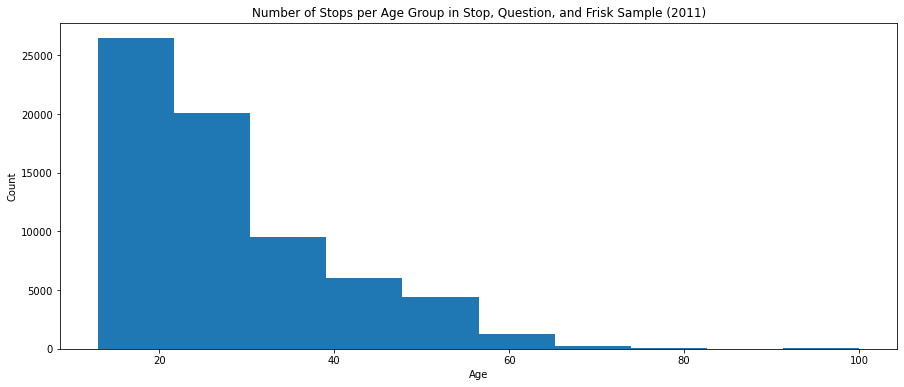

In [64]:
plt.figure(figsize=(15,6))
plt.hist(sqf2011_final['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Number of Stops per Age Group in Stop, Question, and Frisk Sample (2011)')
plt.show()

Based on this histogram of the ages of people stopped in 2011, it seems that most of the stops in our sample occurred between ages 15 and 80. There seem to be some outliers of people stopped who were around age 100.

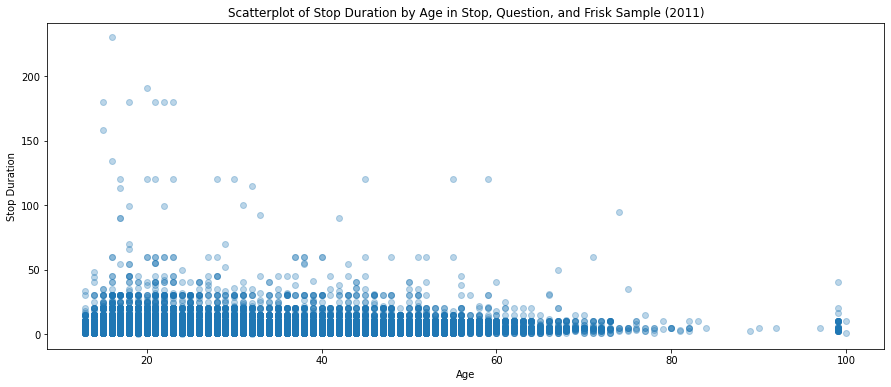

In [65]:
plt.figure(figsize=(15,6))
plt.scatter(sqf2011_final['age'], sqf2011_final['stop_duration'], alpha = 0.3)
plt.xlabel('Age')
plt.ylabel('Stop Duration')
plt.title('Scatterplot of Stop Duration by Age in Stop, Question, and Frisk Sample (2011)')
plt.show()


This scatterplot indicates a trend in the length of stop duration. The concentration of data points below 200 minutes suggest that most of the stops do not last more than ~150 minutes regardless of age. However, there are some outliers that seem to last hours that occur more with younger suspects than older suspects.

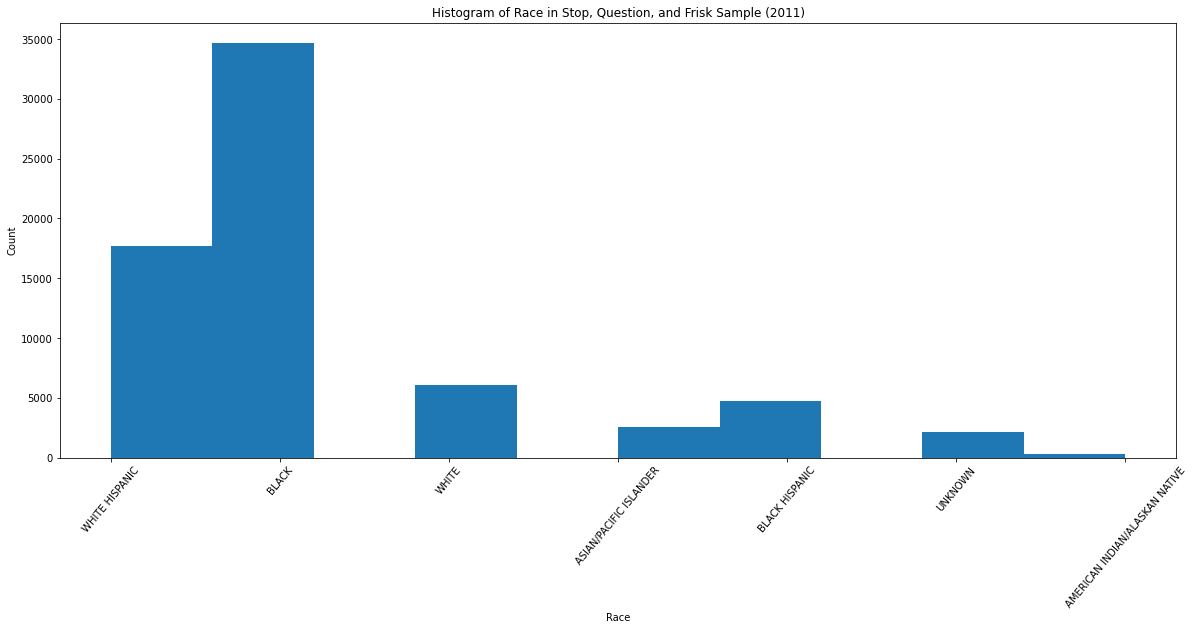

In [66]:
plt.figure(figsize=(20, 8))
plt.hist(sqf2011_final['race'],histtype='bar')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Histogram of Race in Stop, Question, and Frisk Sample (2011)')
plt.xticks(rotation=50)
plt.show()

This bar chart of frequency by race shows that Black people were stopped the most in 2011 and American Indian/Alaskan Native were stopped the least. One thing that would be interesting to explore based on this distribution is what the demographics in New York City looked like during this year. Perhaps Black stops look more prevalent because there was a greater proportion of Black residents in New York City. With American Indian/Alaskan Natives, perhaps they look like they were stopped the least because there is simply less American Indian/Alaskan Natives living in New York City. For future analysis, it will definitely be necessary to identify if these different proportions were due to chance, or were statistically significant.

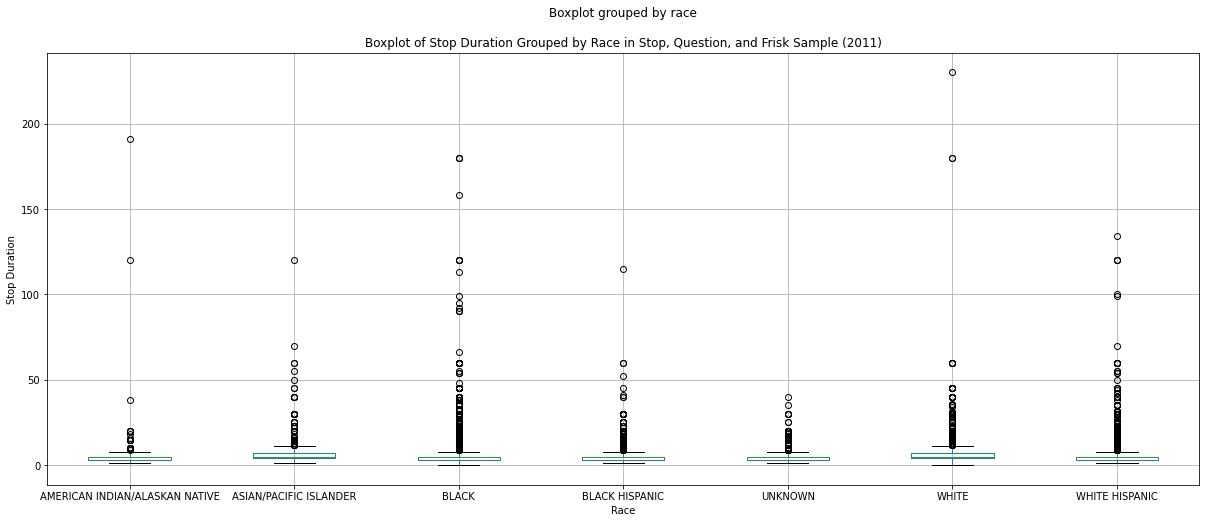

In [67]:
sqf2011_final.boxplot(column=['stop_duration'], by= ['race'], figsize=(20,8))
plt.xlabel('Race')
plt.ylabel('Stop Duration')
plt.title('Boxplot of Stop Duration Grouped by Race in Stop, Question, and Frisk Sample (2011)')
plt.show()

Because of the abundance of outliers present in this sample, it is hard to get a good look at the boxplots; they are very smushed. Let's zoom in so we can see the boxplots themselves:

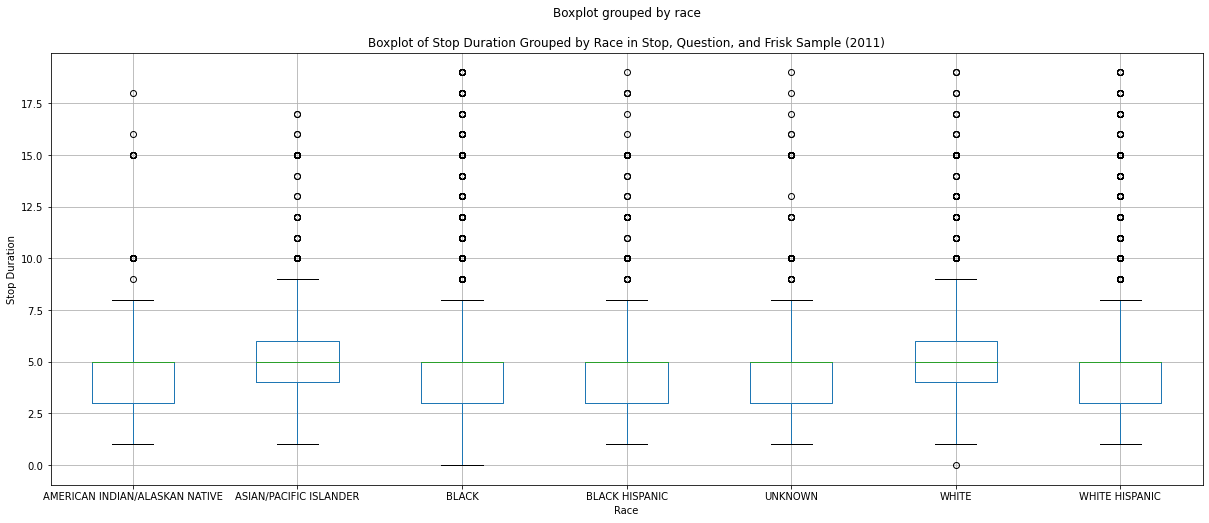

In [68]:
boxplot_zoomIn_race_stop = sqf2011_final.sort_values(by = 'stop_duration', ascending = False)

boxplot_zoomIn_race_stop.loc[boxplot_zoomIn_race_stop['stop_duration'] < 20].boxplot(column=['stop_duration'], by= ['race'], figsize=(20,8))
plt.xlabel('Race')
plt.ylabel('Stop Duration')
plt.title('Boxplot of Stop Duration Grouped by Race in Stop, Question, and Frisk Sample (2011)')
plt.show()

What is interesting about the boxplots is that the median stop duration is the same across race. The 25th and 75th percentiles vary across race. What is interesting to not is that for many race categories, the 75th percentile is equal to the median. This is probably because of the abundance of outliers in the sample.

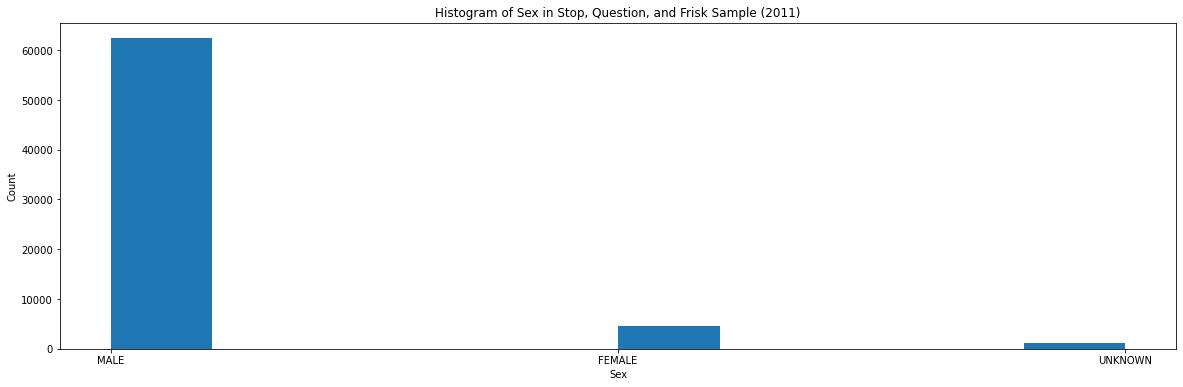

In [69]:
plt.figure(figsize=(20, 6))
plt.hist(sqf2011_final['sex'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Histogram of Sex in Stop, Question, and Frisk Sample (2011)')
plt.show()

There are many more males than females present in this sample.

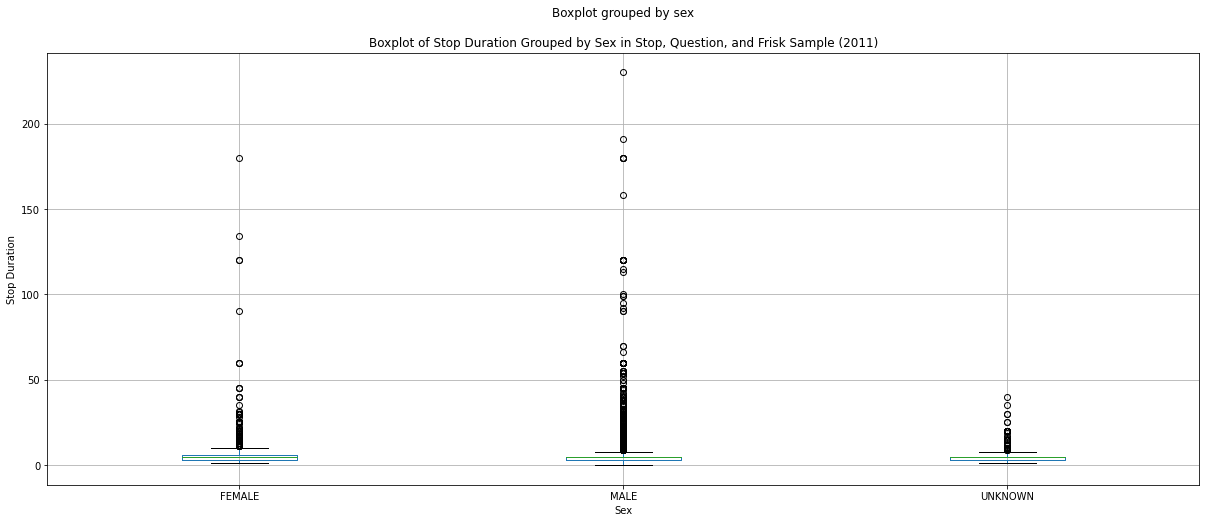

In [70]:
sqf2011_final.boxplot(column=['stop_duration'], by= ['sex'], figsize=(20,8))
plt.xlabel('Sex')
plt.ylabel('Stop Duration')
plt.title('Boxplot of Stop Duration Grouped by Sex in Stop, Question, and Frisk Sample (2011)')
plt.show()

Again, it is hard to see the boxplots of stop duration grouped by sex. Let's zoom in again:

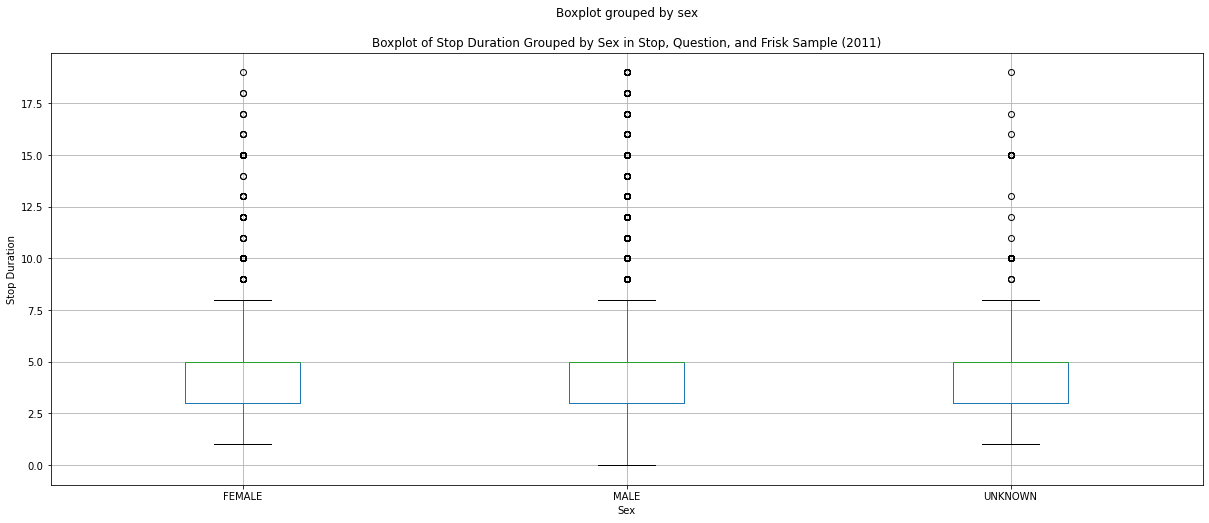

In [71]:
boxplot_zoomIn_sex_stop = sqf2011_final.sort_values(by = 'stop_duration', ascending = False)

boxplot_zoomIn_sex_stop.loc[boxplot_zoomIn_sex_stop['stop_duration'] < 20].boxplot(column=['stop_duration'], by= ['sex'], figsize=(20,8))
plt.xlabel('Sex')
plt.ylabel('Stop Duration')
plt.title('Boxplot of Stop Duration Grouped by Sex in Stop, Question, and Frisk Sample (2011)')
plt.show()

The IQR looks to be about the same across sex, meaning the median stop duration, the 25th percentile stop duration, and the 75th stop duration across sex is roughly the same.

Further analysis is needed, but these visuals of the Stop, Question, and Frisk (2011) dataset gives us a good idea what we are working with.

#### Dataset #2: Stop, Question, and Frisk (2019)

---

First, I am reloading the finalized Stop, Question, and Frisk 2019 dataset to get a visual of its contents.

In [72]:
sqf2019_final=sqf2019_sample3.copy()
sqf2019_final.head()

,date,time,year,obs_duration,crime_sus,stop_duration,off_explain,other_stop,arstmade,arstoffn,sumissue,frisked,searched,contraband,firearm,knife,age,sex,race,boro,other_weapon,phys_force,pt_draw_force
0,2019-11-27,21:31:00,2019,1,CPW,9,True,True,False,,False,True,False,False,False,True,22,MALE,WHITE HISPANIC,MANHATTAN,True,True,False
1,2019-06-09,09:00:00,2019,1,ASSAULT,20,True,True,False,,False,False,False,False,False,False,25,FEMALE,WHITE,BROOKLYN,False,True,False
2,2019-03-29,16:15:00,2019,5,CPW,15,True,True,True,CPW,False,True,True,False,False,True,19,MALE,BLACK,MANHATTAN,True,True,False
3,2019-10-31,20:16:00,2019,1,CRIMINAL MISCHIEF,6,True,True,False,,False,False,False,False,False,False,17,FEMALE,BLACK,QUEENS,False,True,False
4,2019-03-22,22:39:00,2019,1,GRAND LARCENY AUTO,35,True,False,False,,False,True,False,False,False,False,21,MALE,BLACK,BRONX,False,True,False


For the continuous variables in this dataset, we used the describe() method to get descriptive statistics. These descriptive statistics include count, mean, standard deviation, minimum, 25th percentile, 50th percentile, 75th percentile, and the maximum value.

In [73]:
sqf2019_describe = sqf2019_final.describe().drop(labels = ['year'], axis = 1)
sqf2019_describe

,obs_duration,stop_duration,age
count,3078.000000,3078.000000,3078.000000
mean,4.257635,11.403509,28.198830
std,61.631293,16.231255,12.036591
min,0.000000,0.000000,13.000000
25%,1.000000,5.000000,19.000000
50%,1.000000,8.000000,25.000000
75%,1.000000,15.000000,35.000000
max,2055.000000,500.000000,83.000000


The descriptive statistics we've calculated for observation duration (obs_duration), stop duration (stop_duration), and age (age) shed some light on the sample we are working with and the nature of the stops present in this sample:

In [74]:
obs_avg2019 = "The average duration that a police officer observes a suspect before stopping them is {:.3f} minutes, with a standard deviation of {:.3f} minutes.".format(sqf2019_describe.loc["mean", "obs_duration"], sqf2019_describe.loc["std", "obs_duration"])
stop_avg2019 = "The average stop lasts {:.3f} minutes, with a standard deviation of {:.3f} minutes.".format(sqf2019_describe.loc["mean", "stop_duration"], sqf2019_describe.loc["std", "stop_duration"])
age_avg2019 = "The average age of people who were stopped is {:.0f}, with a standard deviation of {:.3f}.".format(sqf2019_describe.loc["mean", "age"], sqf2019_describe.loc["std", "age"])
print(obs_avg2019)
print(stop_avg2019)
print(age_avg2019)

The average duration that a police officer observes a suspect before stopping them is 4.258 minutes, with a standard deviation of 61.631 minutes.
The average stop lasts 11.404 minutes, with a standard deviation of 16.231 minutes.
The average age of people who were stopped is 28, with a standard deviation of 12.037.


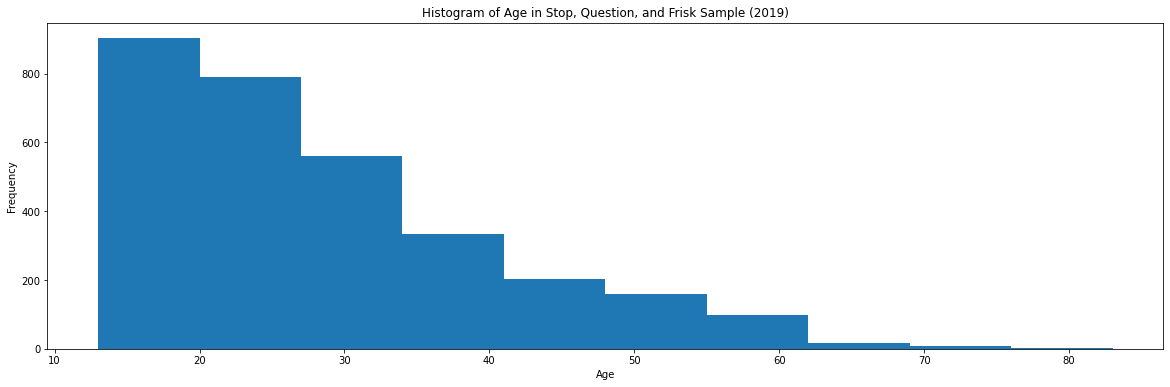

In [75]:
#Histogram of age
plt.figure(figsize=(20, 6))
plt.hist(sqf2019_final['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age in Stop, Question, and Frisk Sample (2019)')
plt.show()

The age at which most stops in 2019 were made is between ~15-30 years old. The least stopped age groups in 2019 are 70-80 year olds.

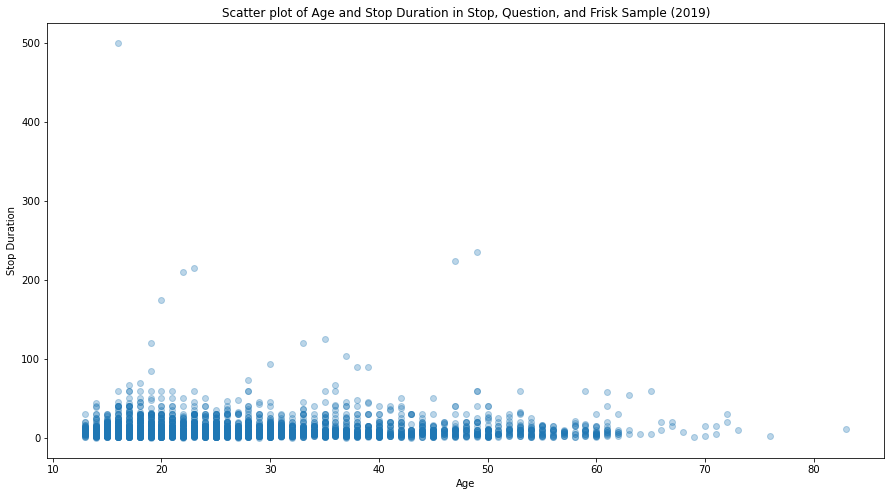

In [76]:
#scatter plot of age and stop duration
plt.figure(figsize=(15,8))
plt.scatter(sqf2019_final['age'], sqf2019_final['stop_duration'], alpha = 0.3)
plt.xlabel('Age')
plt.ylabel('Stop Duration')
plt.title('Scatter plot of Age and Stop Duration in Stop, Question, and Frisk Sample (2019)')
plt.show()

According to the scatter plot, most stop durations are less than 50 minutes long no matter the age. There does not seem to be a strong correlation in the data between age and stop duration.

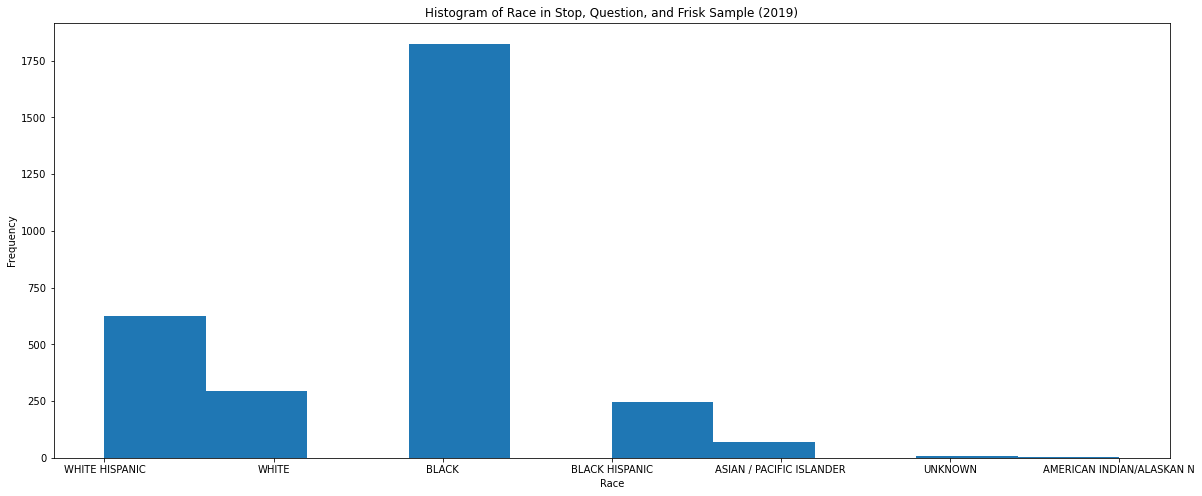

In [77]:
#Histogram of Race ///should be bar graph but but bar graph function is weird!!!!
plt.figure(figsize=(20,8))
plt.hist(sqf2019_final['race'],histtype='bar')#idk how to make this look prettier
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Histogram of Race in Stop, Question, and Frisk Sample (2019)')

plt.show()

The histogram of races show that out of all races in the sample, Black people were stopped the most in 2019 and American Indian/Alaskan the least, excluding the unknown race category.

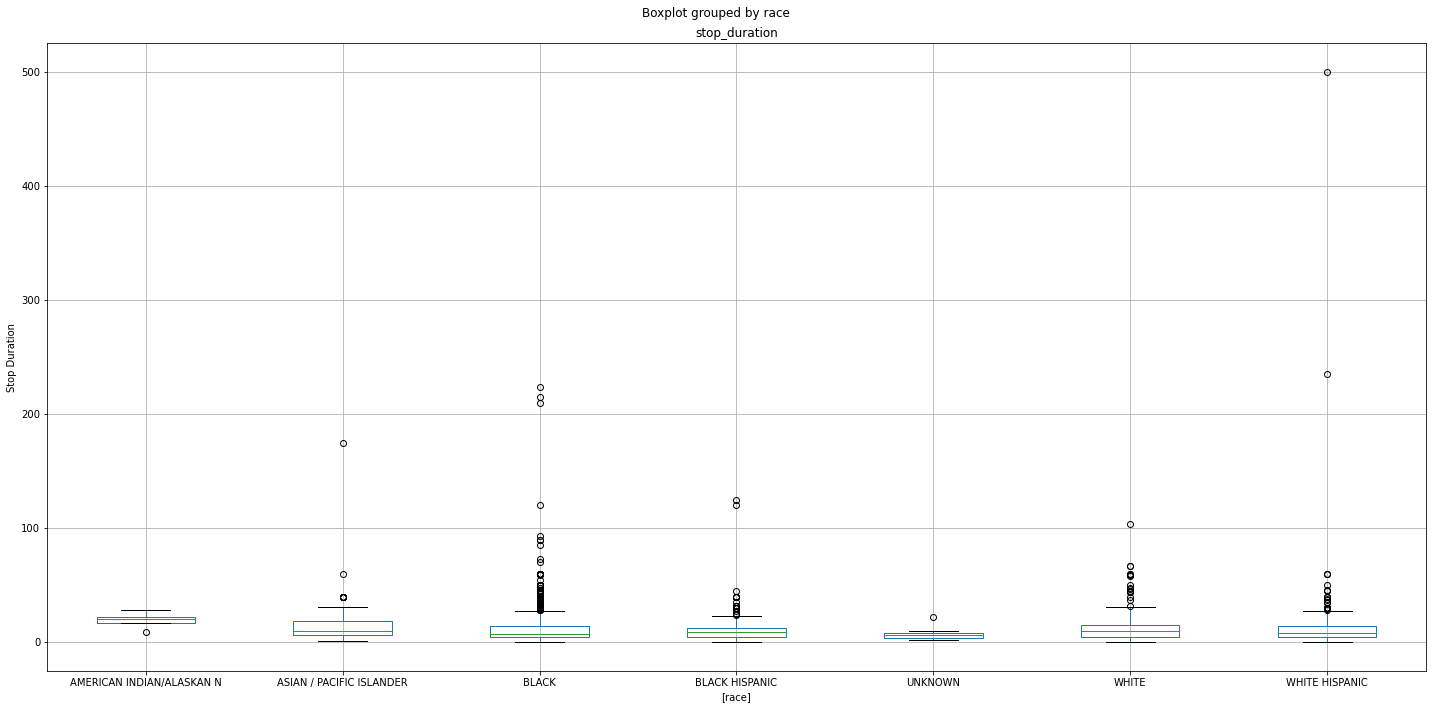

In [78]:
#Boxplot of race and stop duration
sqf2019_final.boxplot(column=['stop_duration'], by= ['race'], figsize=(20,10))
plt.ylabel('Stop Duration')
plt.tight_layout()
plt.show()

According to the boxplot, the median stop durations are about the same no matter the race. The interquartile ranges for each race are close as well. However, the range of stop times with Black and Black Hispanic having the greatest ranges in this sample.

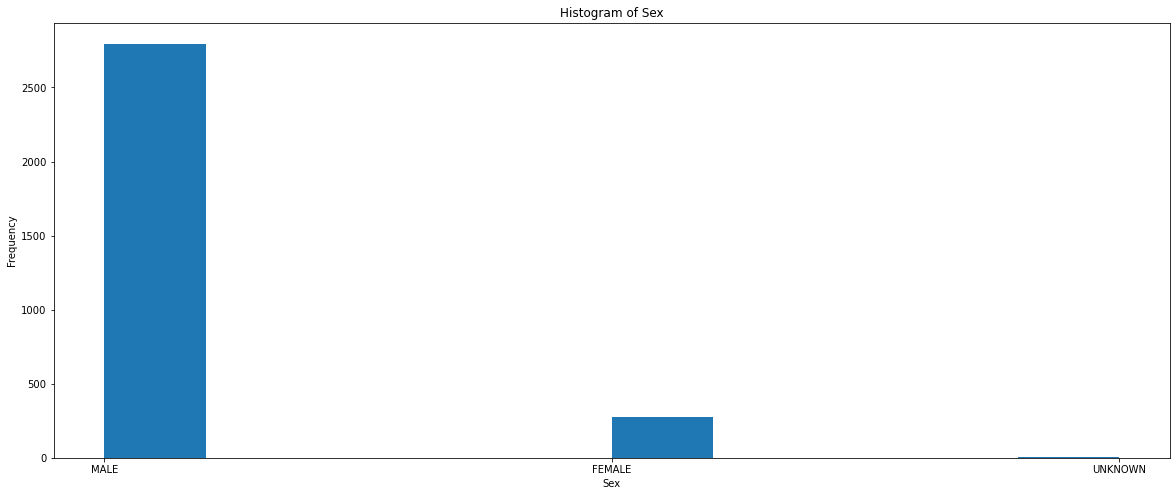

In [79]:
#Histogram of sex
plt.figure(figsize=(20,8))
plt.hist(sqf2019_final['sex'])
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Histogram of Sex')
plt.show()

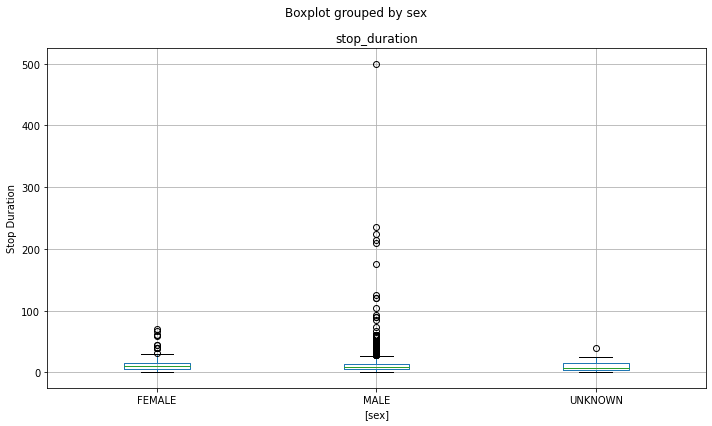

In [80]:
#stop duration by sex
sqf2019_final.boxplot(column=['stop_duration'], by= ['sex'], figsize=(10,6))
plt.ylabel('Stop Duration')
plt.tight_layout()
plt.show()

The graph above shows that a lot more males were stopped than females in 2019. The boxplot shows that the range and IQR of stop durations for females and males is about the same. However, more males have longer stop durations than females.

#### Dataset #3: Criminal Offense Data (2009-2019)

---

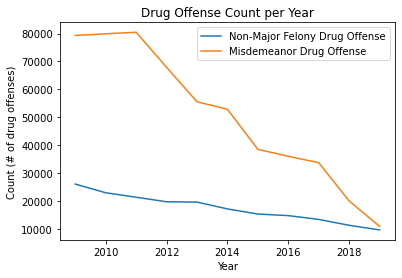

In [81]:
# Drug Misdemeanor count over the years
plt.plot(crime_data.iloc[11,1:12], label = 'Non-Major Felony Drug Offense')
plt.plot(crime_data.iloc[17,1:12], label = 'Misdemeanor Drug Offense')

plt.title('Drug Offense Count per Year')
plt.xlabel('Year')
plt.ylabel('Count (# of drug offenses)')
plt.legend(loc='upper right')
plt.show()

The graph above shows the count of Non-Major Felony Drug Offenses and Misdemeanor Drug Offenses, respectively, from 2009 to 2019. Both variables decreased dramatically over the given time period. Non-Major Felony Drug Offenses fell 63.16%, from 26,025 to 9,587. Misdemeanor Felony Drug Offenses fell 86.31%, from 79,302 to 10,854. 

In [82]:
# Calculations Used in Above Description:
nm_2009 = crime_data.iloc[11,1]
#print(nm_2009)
nm_2019 = crime_data.iloc[11,11]
#print(nm_2019)
nm_change = (1 - (nm_2019/nm_2009)) * 100
#print(nm_change)

m_2009 = crime_data.iloc[17,1]
#print(m_2009)
m_2019 = crime_data.iloc[17,11]
#print(m_2019)
m_change = (1 - (m_2019/m_2009)) * 100
#print(m_change)

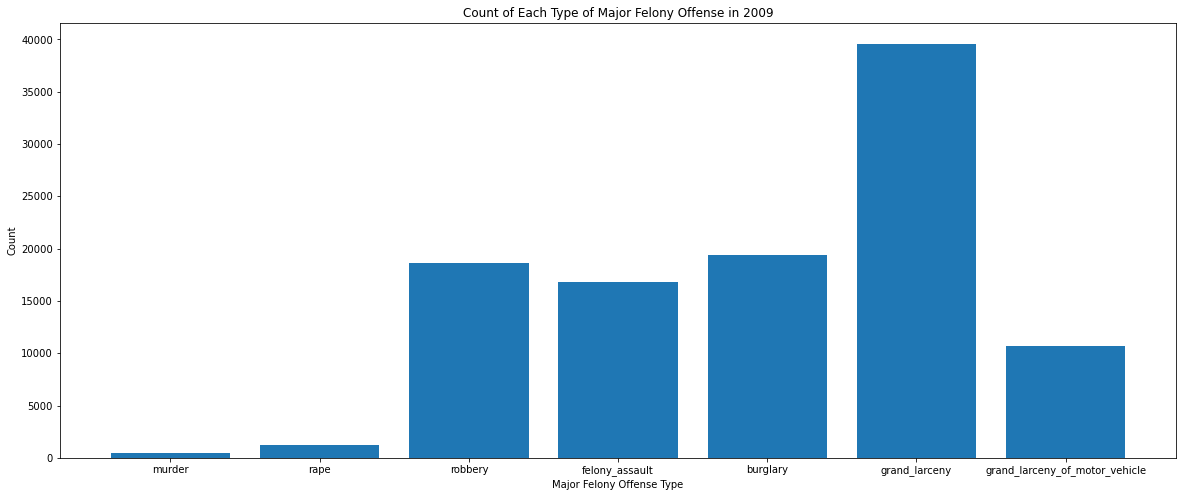

In [83]:
#Bar Graph of 2009 Felony Offenses

plt.figure(figsize=(20,8))
plt.bar(crime_data[crime_data['status'] == 'major_felony'].offense, crime_data[crime_data['status'] == 'major_felony'][2009])
plt.title('Count of Each Type of Major Felony Offense in 2009')
plt.xlabel('Major Felony Offense Type')
plt.ylabel('Count')
plt.show()

The bar graph above shows that in 2009 grand larceny was the most popular felony offense reported by the NYPD (39,580). The number of felony robberies (18,601), assaults (16,773), and burglaries (19430) were roughly half the count of felony grand larceny offenses, respectively. The counts of murder (471) and rape (1205) are both minimal relative to the number other felony offenses in 2009, though they are much more serious crimes.

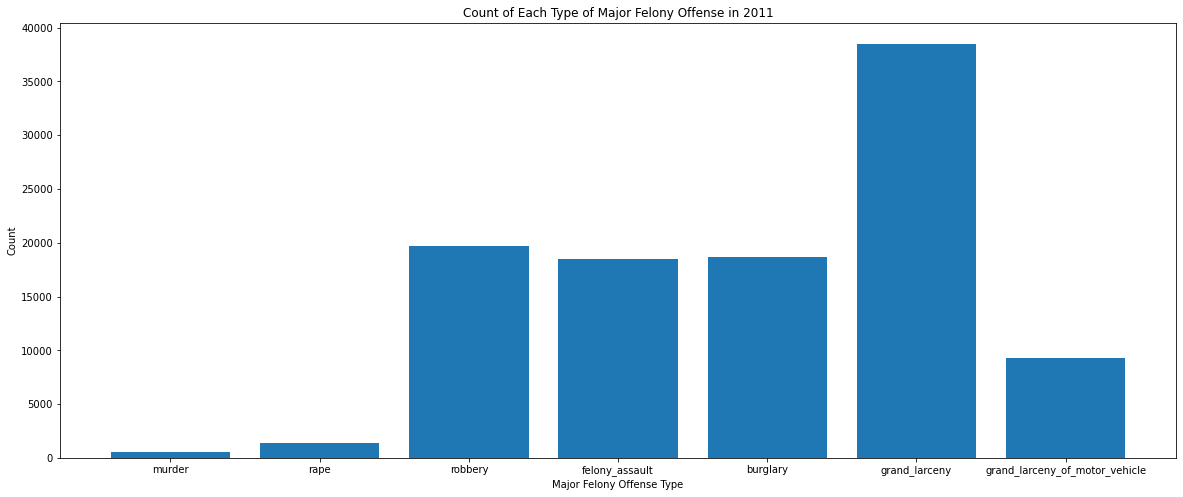

In [84]:
#Bar Graph of 2011 Felony Offenses

plt.figure(figsize=(20,8))
plt.bar(crime_data[crime_data['status'] == 'major_felony'].offense, crime_data[crime_data['status'] == 'major_felony'][2011])
plt.title('Count of Each Type of Major Felony Offense in 2011')
plt.xlabel('Major Felony Offense Type')
plt.ylabel('Count')
plt.show()

The bar graph above shows the distribution of felony offenses in 2011 as nearly identical to the distribution in 2009 (see previous bar graph).

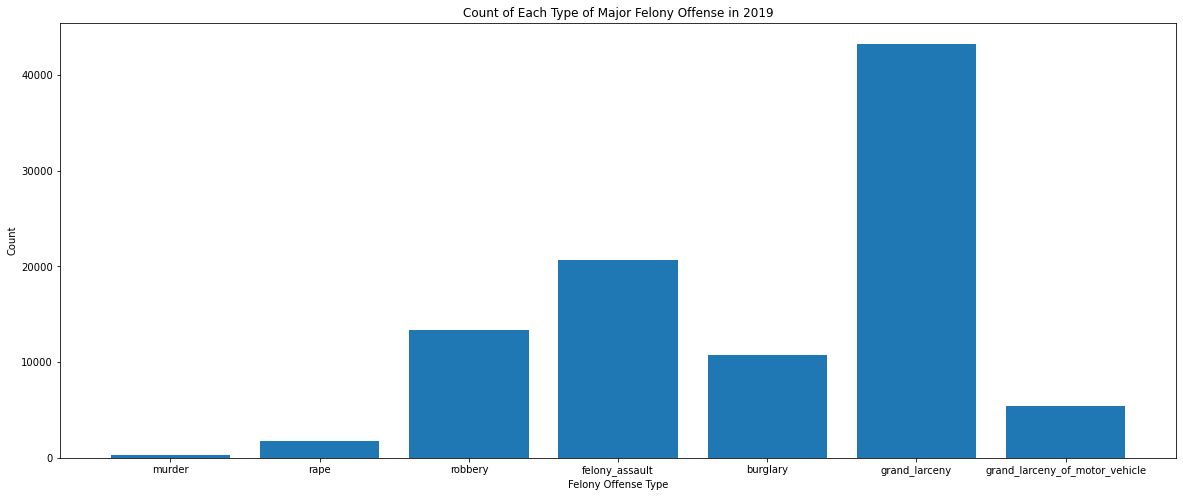

In [85]:
#Bar Graph of 2019 Felony Offenses

plt.figure(figsize=(20,8))
plt.bar(crime_data[crime_data['status'] == 'major_felony'].offense, crime_data[crime_data['status'] == 'major_felony'][2019])
plt.title('Count of Each Type of Major Felony Offense in 2019')
plt.xlabel('Felony Offense Type')
plt.ylabel('Count')
plt.show()

The bar graph above shows the count of each type of felony offense in 2019. The number of felony robbery, burglary, and grand larceny of a motor vehicle offenses have each fallen substantially since 2009. However, the number of felony grand larceny offenses did not decrease nor from it's position as most popular offense. Overall, there appears to not be a significant change in felony offenses reported in 2009 versus 2019.

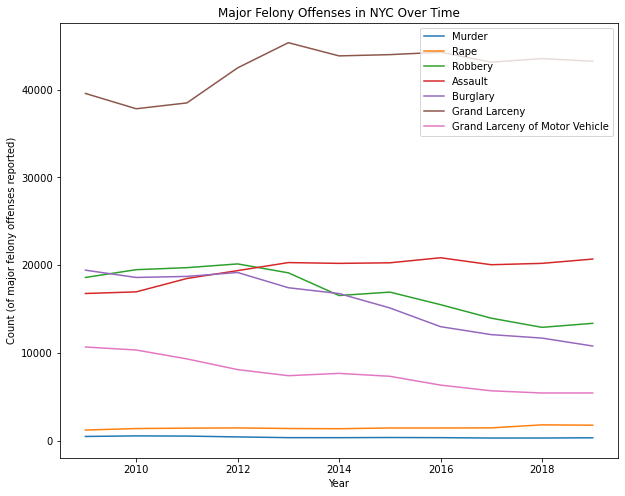

In [86]:
# Graph Each Felony over Time (2009-2019)

plt.figure(figsize=(10,8))
plt.plot(crime_data.iloc[0,1:12], label = 'Murder')
plt.plot(crime_data.iloc[1,1:12], label = 'Rape')
plt.plot(crime_data.iloc[2,1:12], label = 'Robbery')
plt.plot(crime_data.iloc[3,1:12], label = 'Assault')
plt.plot(crime_data.iloc[4,1:12], label = 'Burglary')
plt.plot(crime_data.iloc[5,1:12], label = 'Grand Larceny')
plt.plot(crime_data.iloc[6,1:12], label = 'Grand Larceny of Motor Vehicle')
plt.xlabel('Year')
plt.ylabel('Count (of major felony offenses reported)')
plt.title('Major Felony Offenses in NYC Over Time')
plt.legend(loc='upper right')
plt.show()

The graph above illustrates the levels of each Major Felony Offense reported in NYC from 2009 to 2019. Grand larceny is consistently the most frequently-committed offense, whereas murder and rape are the least-frequently commited offenses.

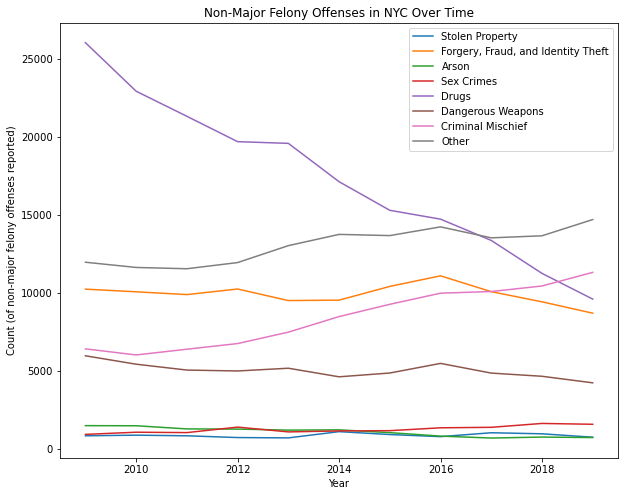

In [87]:
# Graph of the NONMajor Felony Offenses in NYC Over Time

plt.figure(figsize=(10,8))
plt.plot(crime_data.iloc[7,1:12], label = 'Stolen Property')
plt.plot(crime_data.iloc[8,1:12], label = 'Forgery, Fraud, and Identity Theft')
plt.plot(crime_data.iloc[9,1:12], label = 'Arson')
plt.plot(crime_data.iloc[10,1:12], label = 'Sex Crimes')
plt.plot(crime_data.iloc[11,1:12], label = 'Drugs')
plt.plot(crime_data.iloc[12,1:12], label = 'Dangerous Weapons')
plt.plot(crime_data.iloc[13,1:12], label = 'Criminal Mischief')
plt.plot(crime_data.iloc[14,1:12], label = 'Other')


plt.xlabel('Year')
plt.ylabel('Count (of non-major felony offenses reported)')
plt.title('Non-Major Felony Offenses in NYC Over Time')
plt.legend(loc='upper right')
plt.show()

The graph above illustrates the levels of each Non-Major Felony Offense reported in NYC from 2009 to 2019. Drug-related crimes were the most frequently-committed Non-Major Felony offense for the majority of the time period (2009 - 2016) but continued to decline dramatically. All other Non-Major Felony offenses remained relatively constant over time.

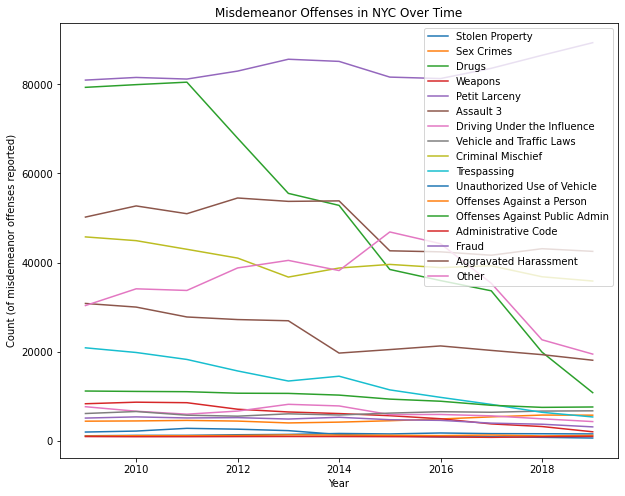

In [88]:
# Graph of the Misdemeanor Offenses in NYC Over Time

plt.figure(figsize=(10,8))
plt.plot(crime_data.iloc[15,1:12], label = 'Stolen Property')
plt.plot(crime_data.iloc[16,1:12], label = 'Sex Crimes')
plt.plot(crime_data.iloc[17,1:12], label = 'Drugs')
plt.plot(crime_data.iloc[18,1:12], label = 'Weapons')
plt.plot(crime_data.iloc[19,1:12], label = 'Petit Larceny')
plt.plot(crime_data.iloc[20,1:12], label = 'Assault 3')
plt.plot(crime_data.iloc[21,1:12], label = 'Driving Under the Influence')
plt.plot(crime_data.iloc[22,1:12], label = 'Vehicle and Traffic Laws')
plt.plot(crime_data.iloc[23,1:12], label = 'Criminal Mischief')
plt.plot(crime_data.iloc[24,1:12], label = 'Trespassing')
plt.plot(crime_data.iloc[25,1:12], label = 'Unauthorized Use of Vehicle')
plt.plot(crime_data.iloc[26,1:12], label = 'Offenses Against a Person')
plt.plot(crime_data.iloc[27,1:12], label = 'Offenses Against Public Admin')
plt.plot(crime_data.iloc[28,1:12], label = 'Administrative Code')
plt.plot(crime_data.iloc[29,1:12], label = 'Fraud')
plt.plot(crime_data.iloc[30,1:12], label = 'Aggravated Harassment')
plt.plot(crime_data.iloc[31,1:12], label = 'Other')

plt.xlabel('Year')
plt.ylabel('Count (of misdemeanor offenses reported)')
plt.title('Misdemeanor Offenses in NYC Over Time')
plt.legend(loc='upper right')
plt.show()

The graph above illustrates the levels of each Misdemeanor Offense reported in NYC from 2009 to 2019. Drug-related crimes were the most frequently-committed Misdemeanor offense for the majority of the time period (2009 - 2016) but continued to decline dramatically. Assault 3 and Driving Under the Influence Misdemeanor offenses appear to have fluctuated over time but there is not a consistent trend in the data. All other Misdemeanor offenses remained relatively constant over time.

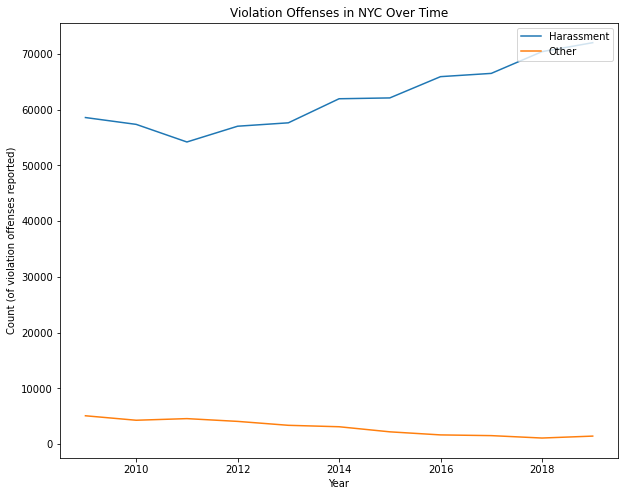

In [89]:
# Graph of the Violation Offenses in NYC Over Time

plt.figure(figsize=(10,8))
plt.plot(crime_data.iloc[32,1:12], label = 'Harassment')
plt.plot(crime_data.iloc[33,1:12], label = 'Other')

plt.xlabel('Year')
plt.ylabel('Count (of violation offenses reported)')
plt.title('Violation Offenses in NYC Over Time')
plt.legend(loc='upper right')
plt.show()

The graph above illustrates the levels of each Violation Offense reported in NYC from 2009 to 2019. The levels of Harassment Violation Offenses are dramatically and consistently greater in number than all other Violation Offenses. Harassment appears to have trended up from 2011 to 2019. All other Violation Offenses appear to be trending down slightly.

### (f) Questions
---

- In both Stop and Frisk datasets (2011 and 2019), there are outliers for stop durations of over 10 hours long. Most stop durations are less than 100 minutes long. We are not sure how to deal with that, if we should remove it from our data or look into it more?
- For the 2011 dataset, the inputs under the crime suspected column are coded differently than the 2019 dataset. 2011 crime suspected uses numbers as labels for types of crimes while 2019 crime suspected column uses a description of the crime (ex: ‘PETIT LARCENY’). How should we connect the two so that they are consistent with each other?
- Any suggestions for what other pair of variables we could look into? 
- What would you do differently?
